$http
[1] "https://gdc.cancer.gov/about-data/publications/pancanatlas"

$paper
[1] "Integrated TCGA Pan-Cancer Clinical Data Resource to Drive High-Quality Survival Outcome Analytics"

[1] 743 429

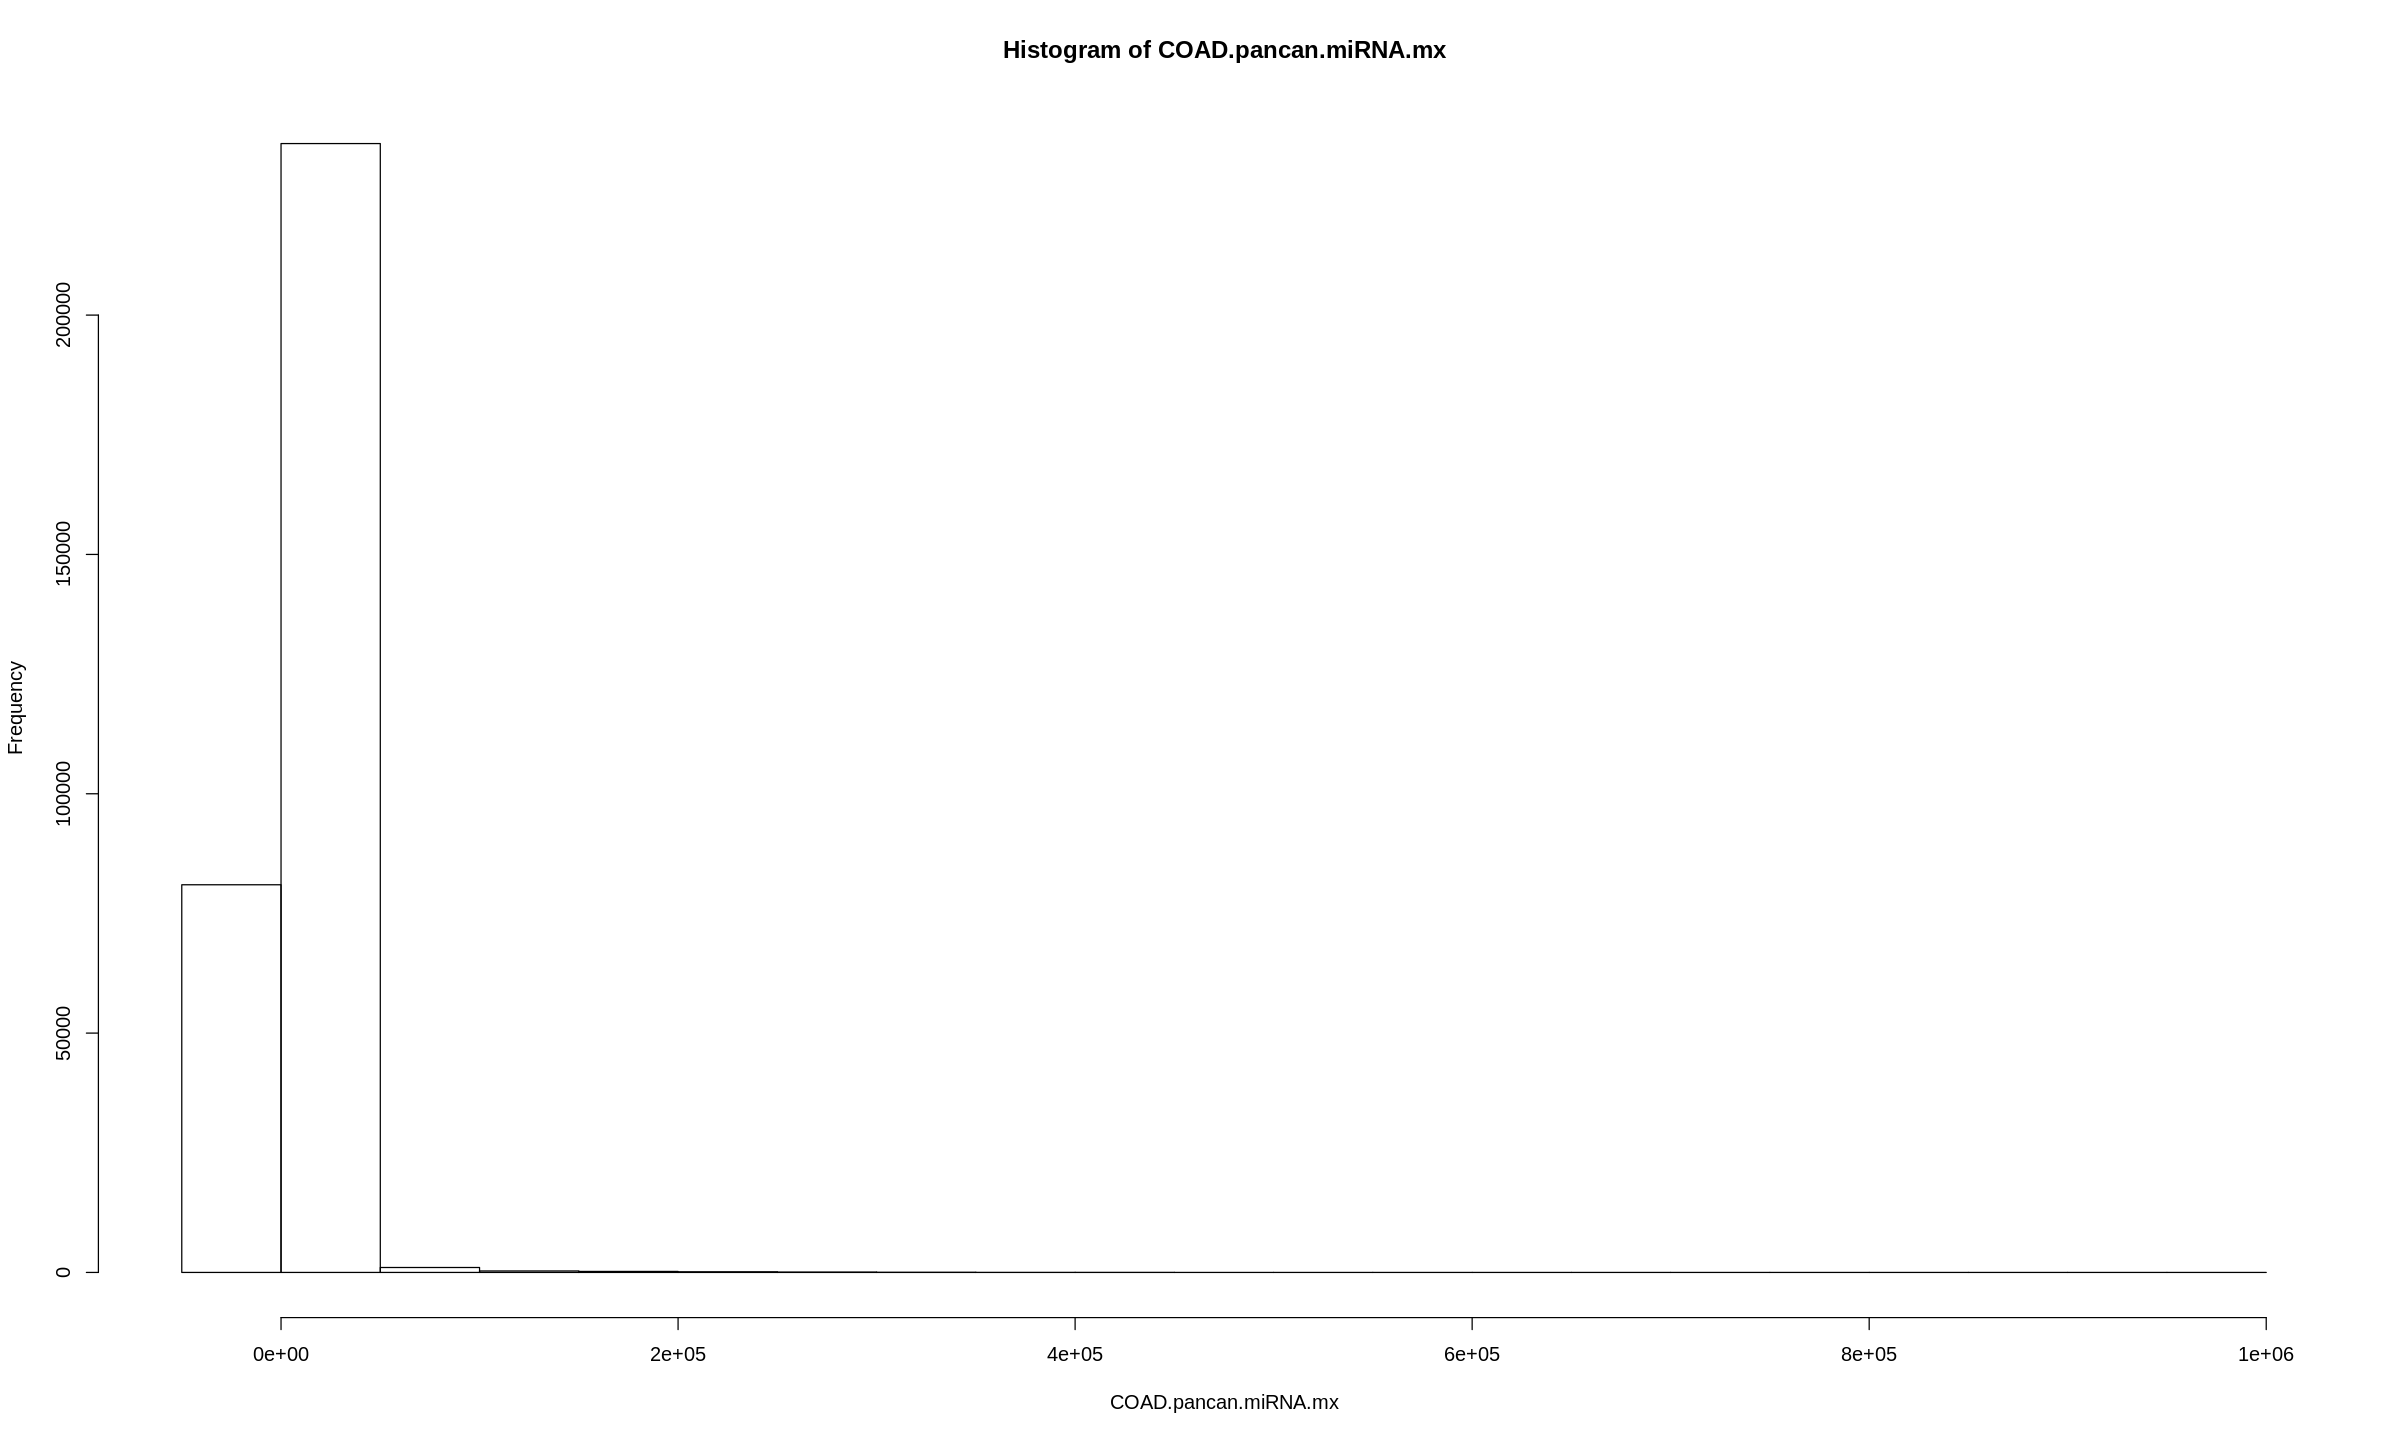

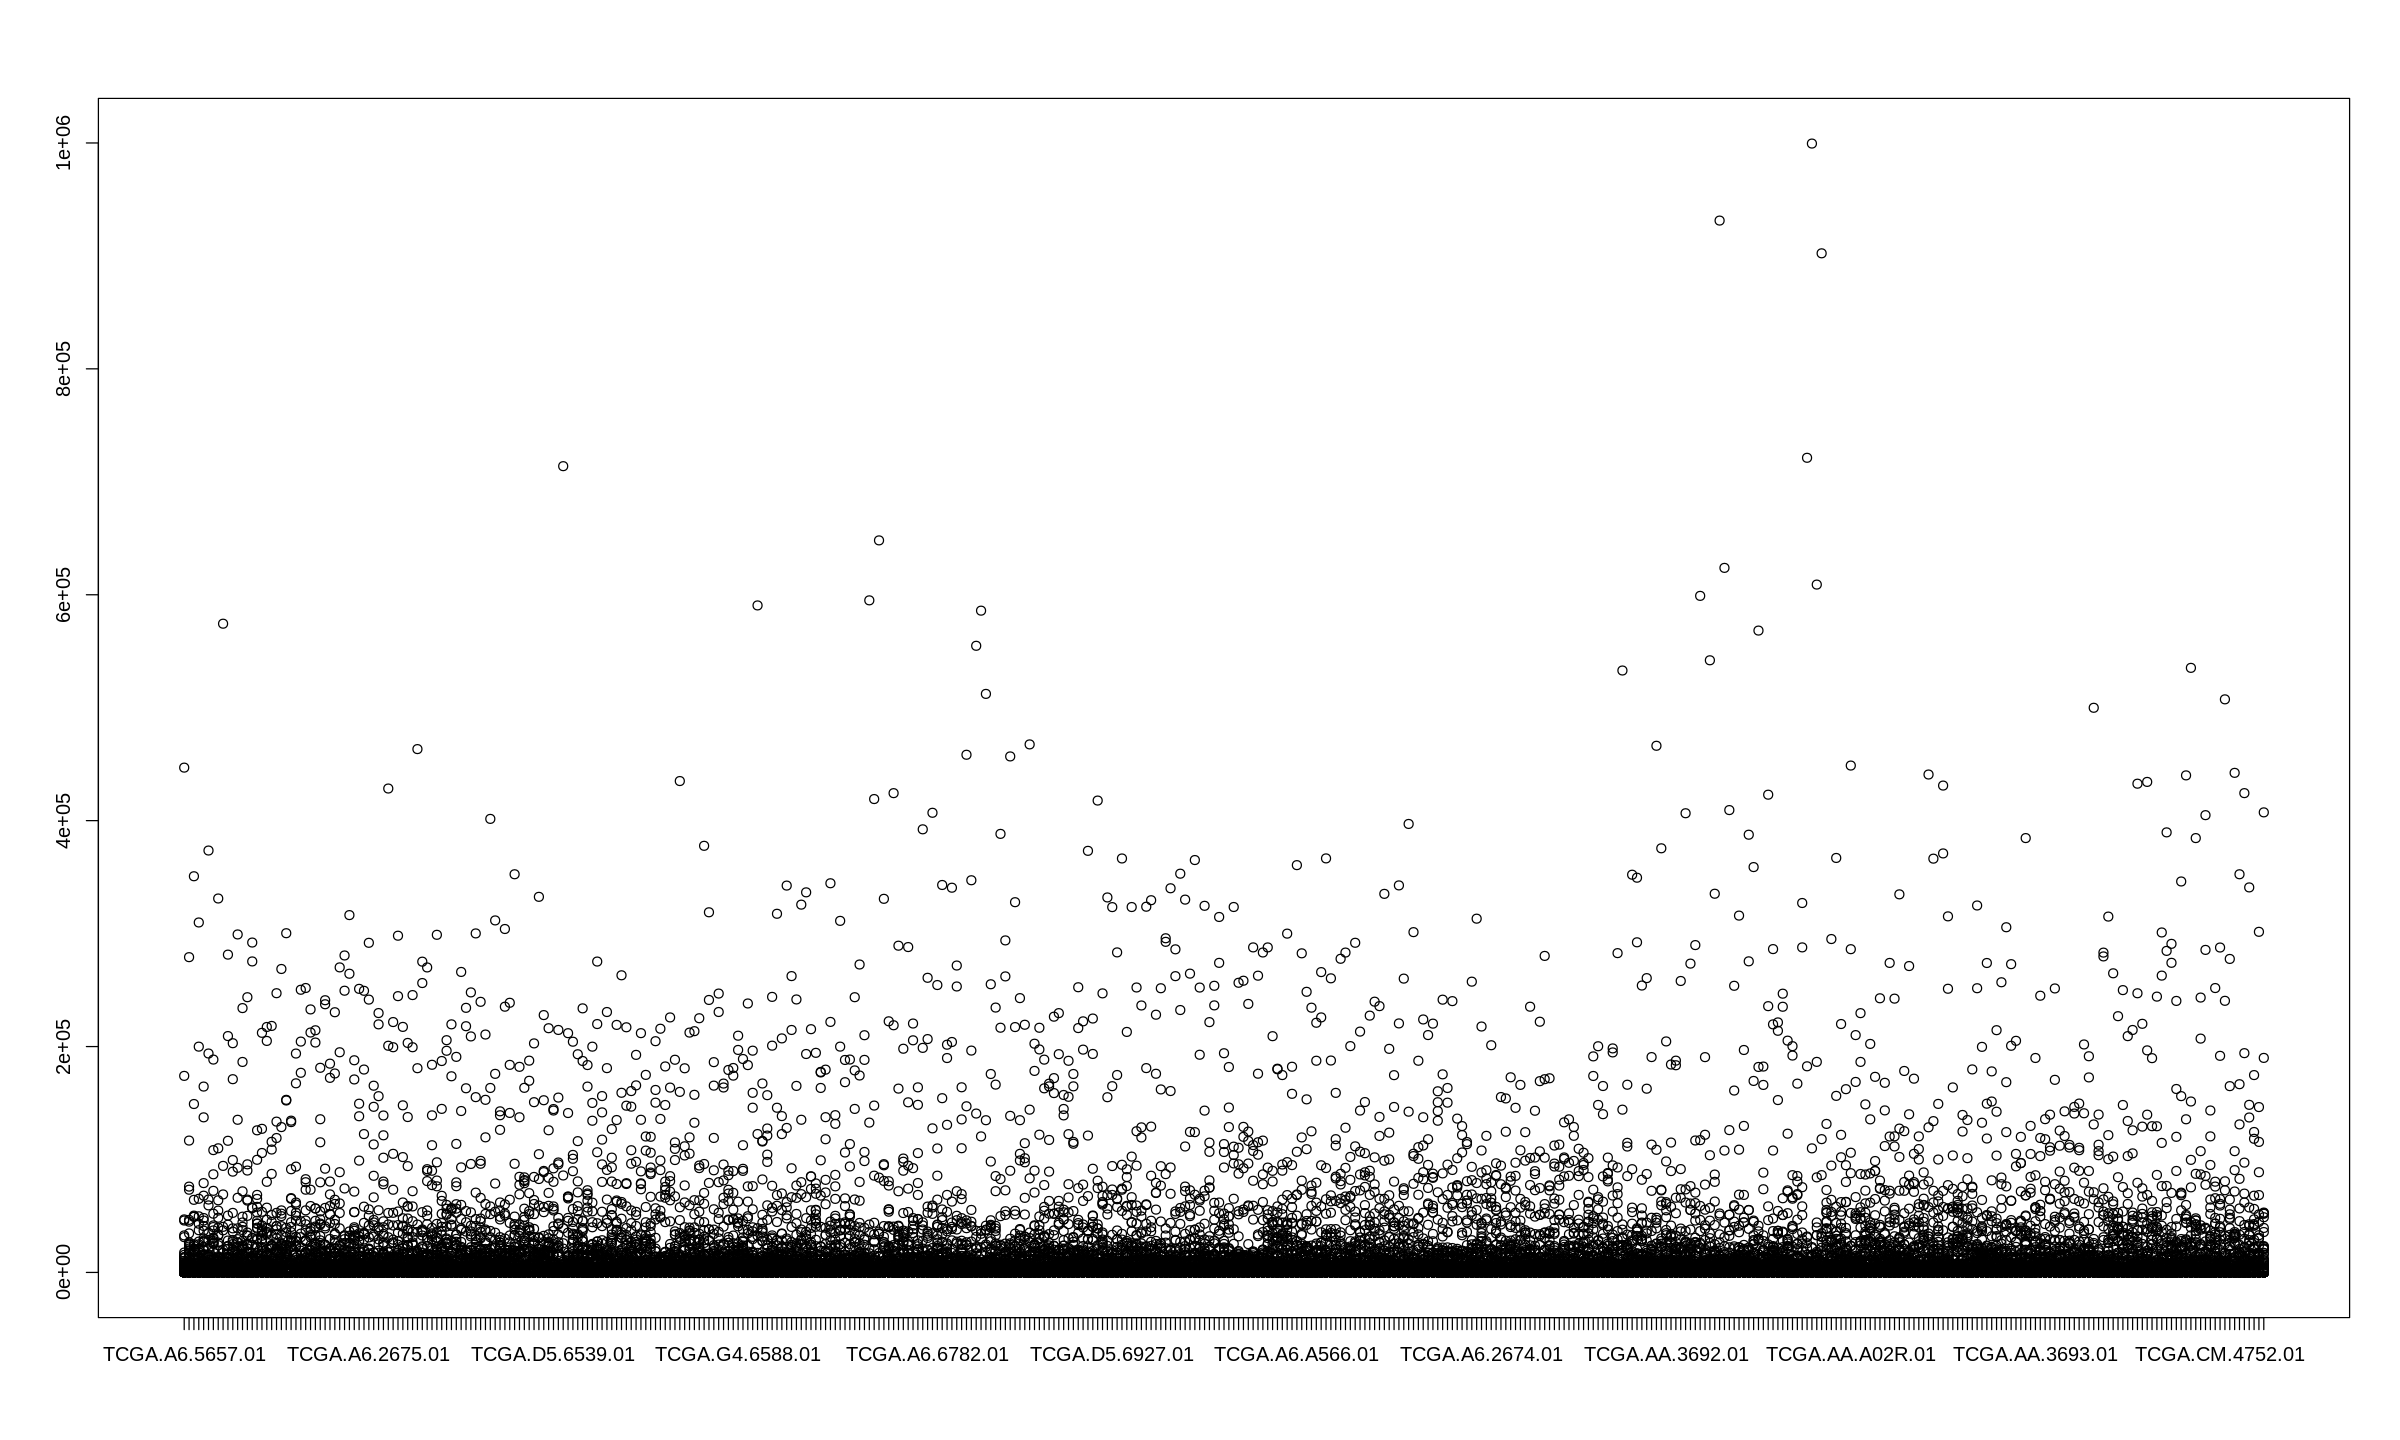

In [2]:
#### 3.miRNA_data_analysis.R
# It's from TCGA PanCancerAtlas_Publish series paper data
# https://gdc.cancer.gov/about-data/publications/pancanatlas
## Using log2(x+1)transformed miRNA value to limma
### 1) Loading miRNA miRNA_Batch_Normalized_dataset 
COAD_PanCancerAtlas_Publish_miRNA_Batch_Normalized_dataset <- readRDS("/data8t_4/JH/MyJobs/Read_dataset/TCGA_PanCancerAtlas_Publications/miRNA_Batch_Effects_Normalized_miRNA/COAD_PanCancerAtlas_Publish_miRNA_Batch_Normalized_dataset.rds")
COAD.pancan.miRNA.mx <- COAD_PanCancerAtlas_Publish_miRNA_Batch_Normalized_dataset$COAD.pancan.miRNA.mx
COAD.pancan.miRNA.mx <- as.matrix(COAD.pancan.miRNA.mx)
COAD_PanCancerAtlas_Publish_miRNA_Batch_Normalized_dataset$metadata
dim(COAD.pancan.miRNA.mx)
hist(COAD.pancan.miRNA.mx)
boxplot(COAD.pancan.miRNA.mx)
### 2)Read cluster resaults
Cluster.20200201.V7.Tumor <- readRDS("/data8t_4/JH/MyJobs/NormalCancer_TCGA_V2/Cluster.20200201.V7.Tumor.rds")
cutree.res <- Cluster.20200201.V7.Tumor$cutree.res
dynamicColors <- Cluster.20200201.V7.Tumor$dynamicColors
Cluster.df <- cbind(cutree.res,dynamicColors) 
Cluster.df <- as.data.frame(Cluster.df)
Cluster.df$rownames <- rownames(Cluster.df)
hclust.Res <- Cluster.20200201.V7.Tumor$hclust.Res


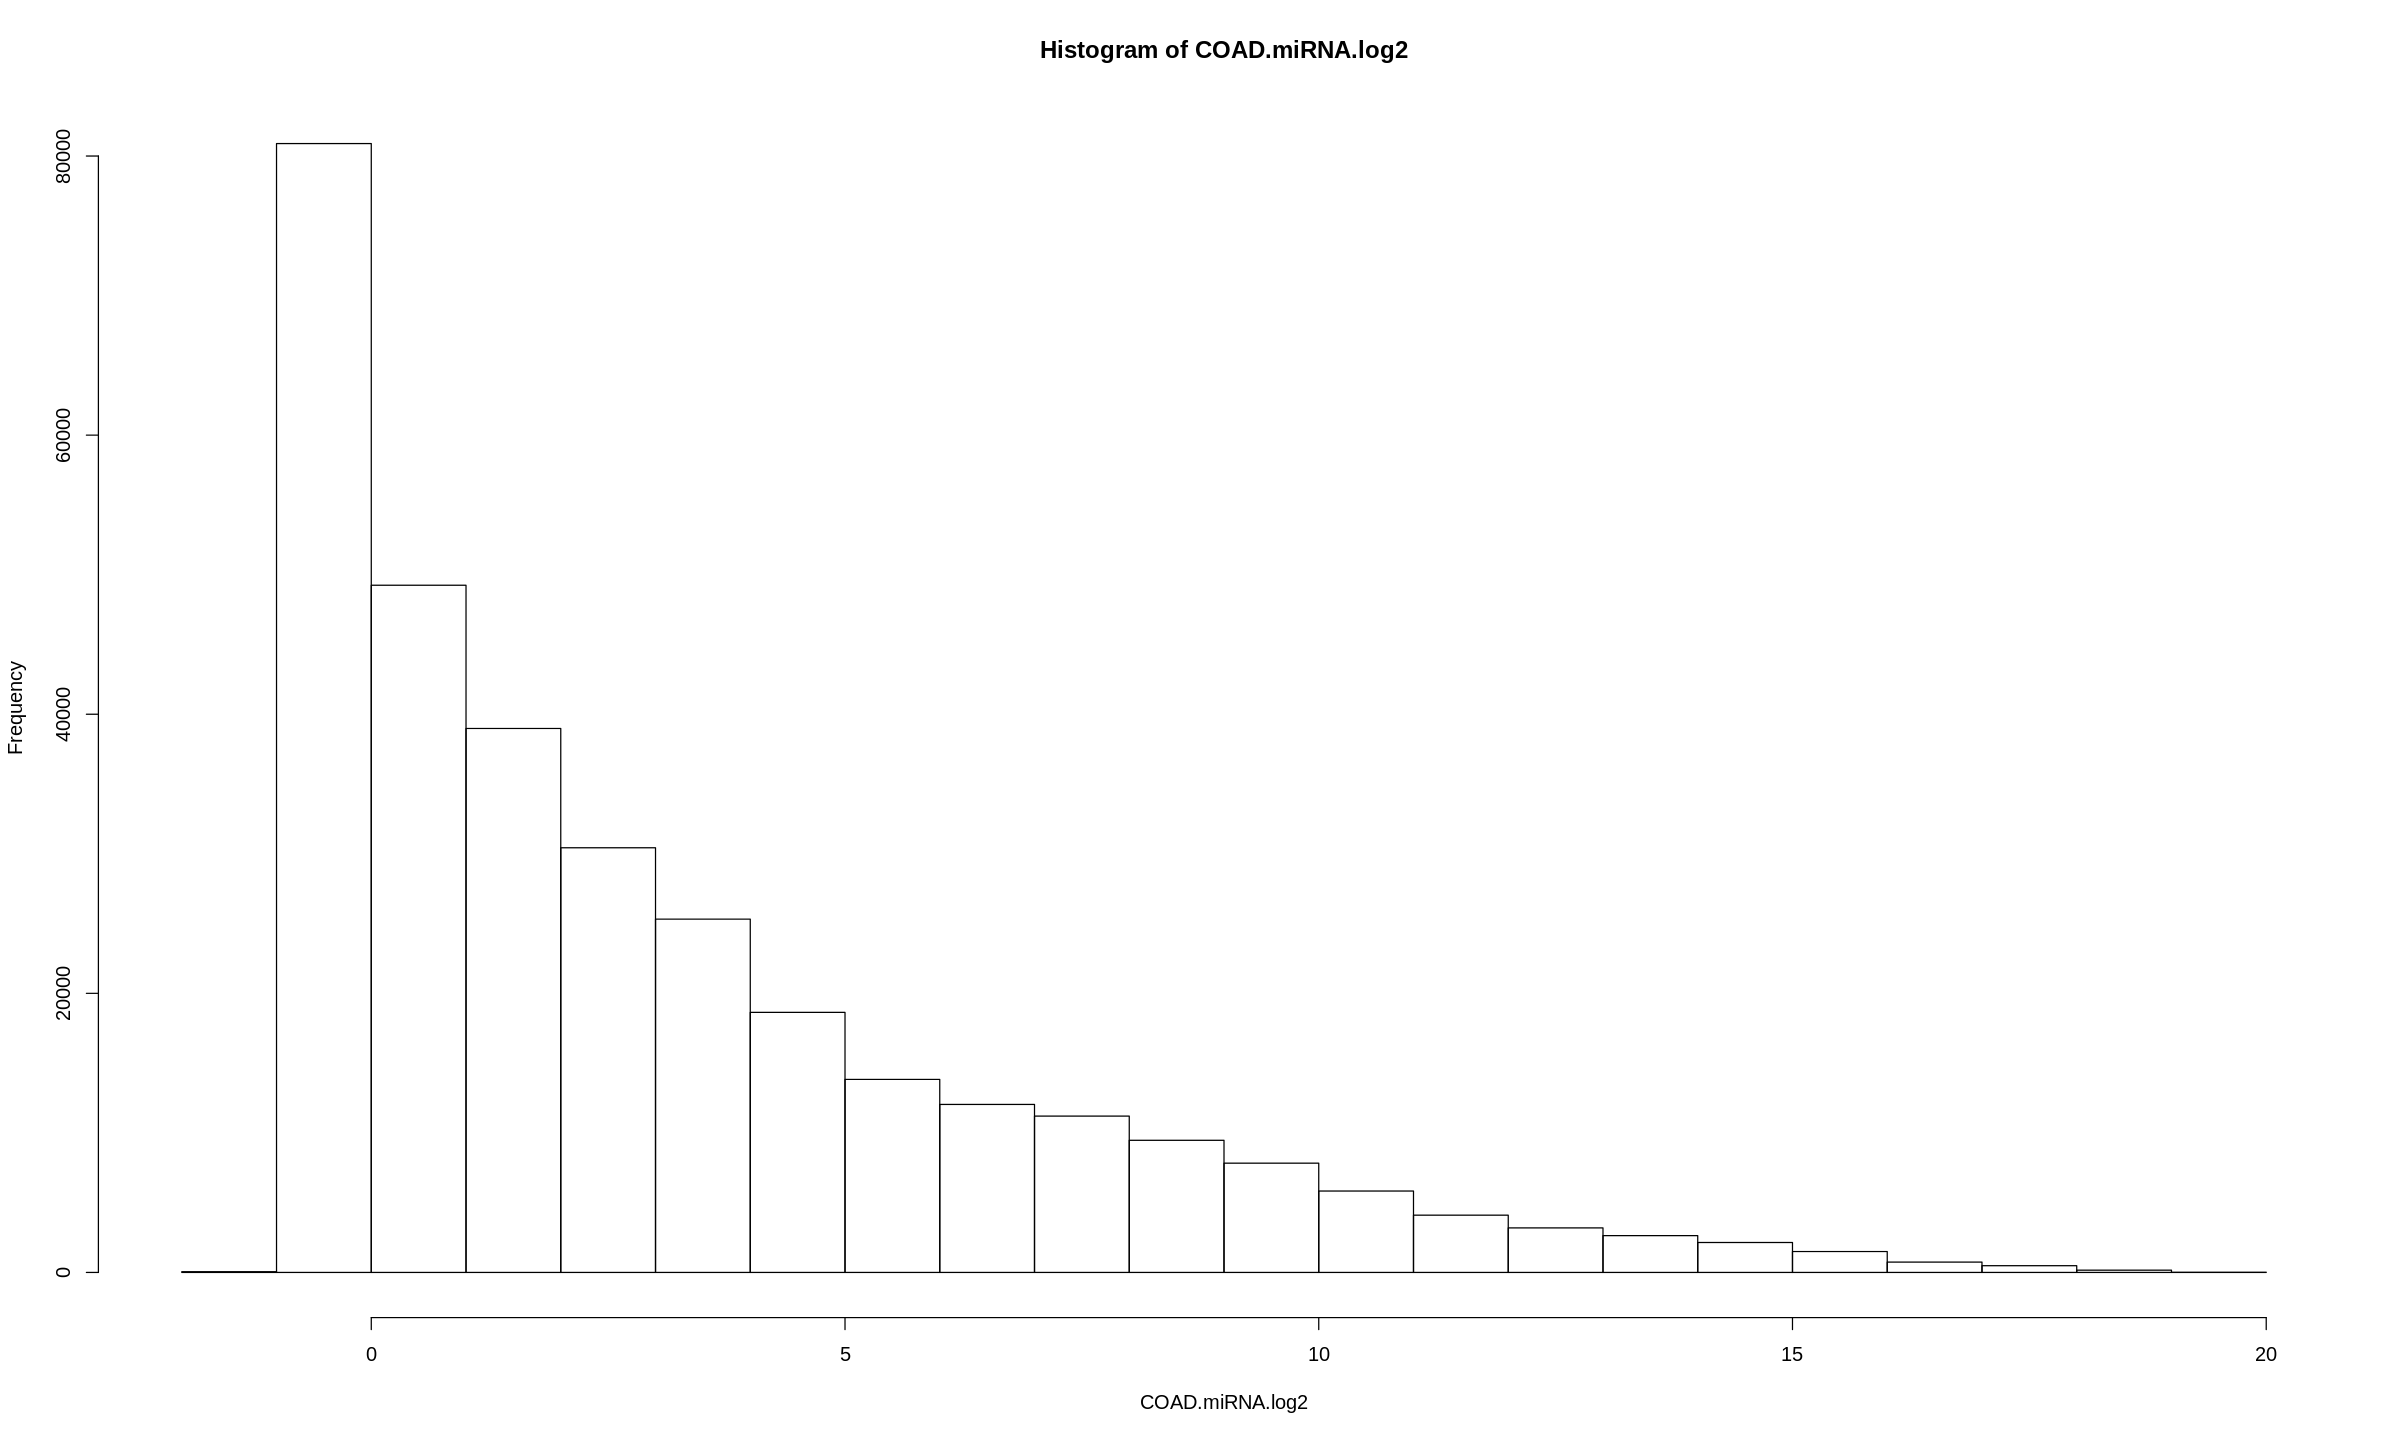

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory mat


FALSE  TRUE 
    8   278 

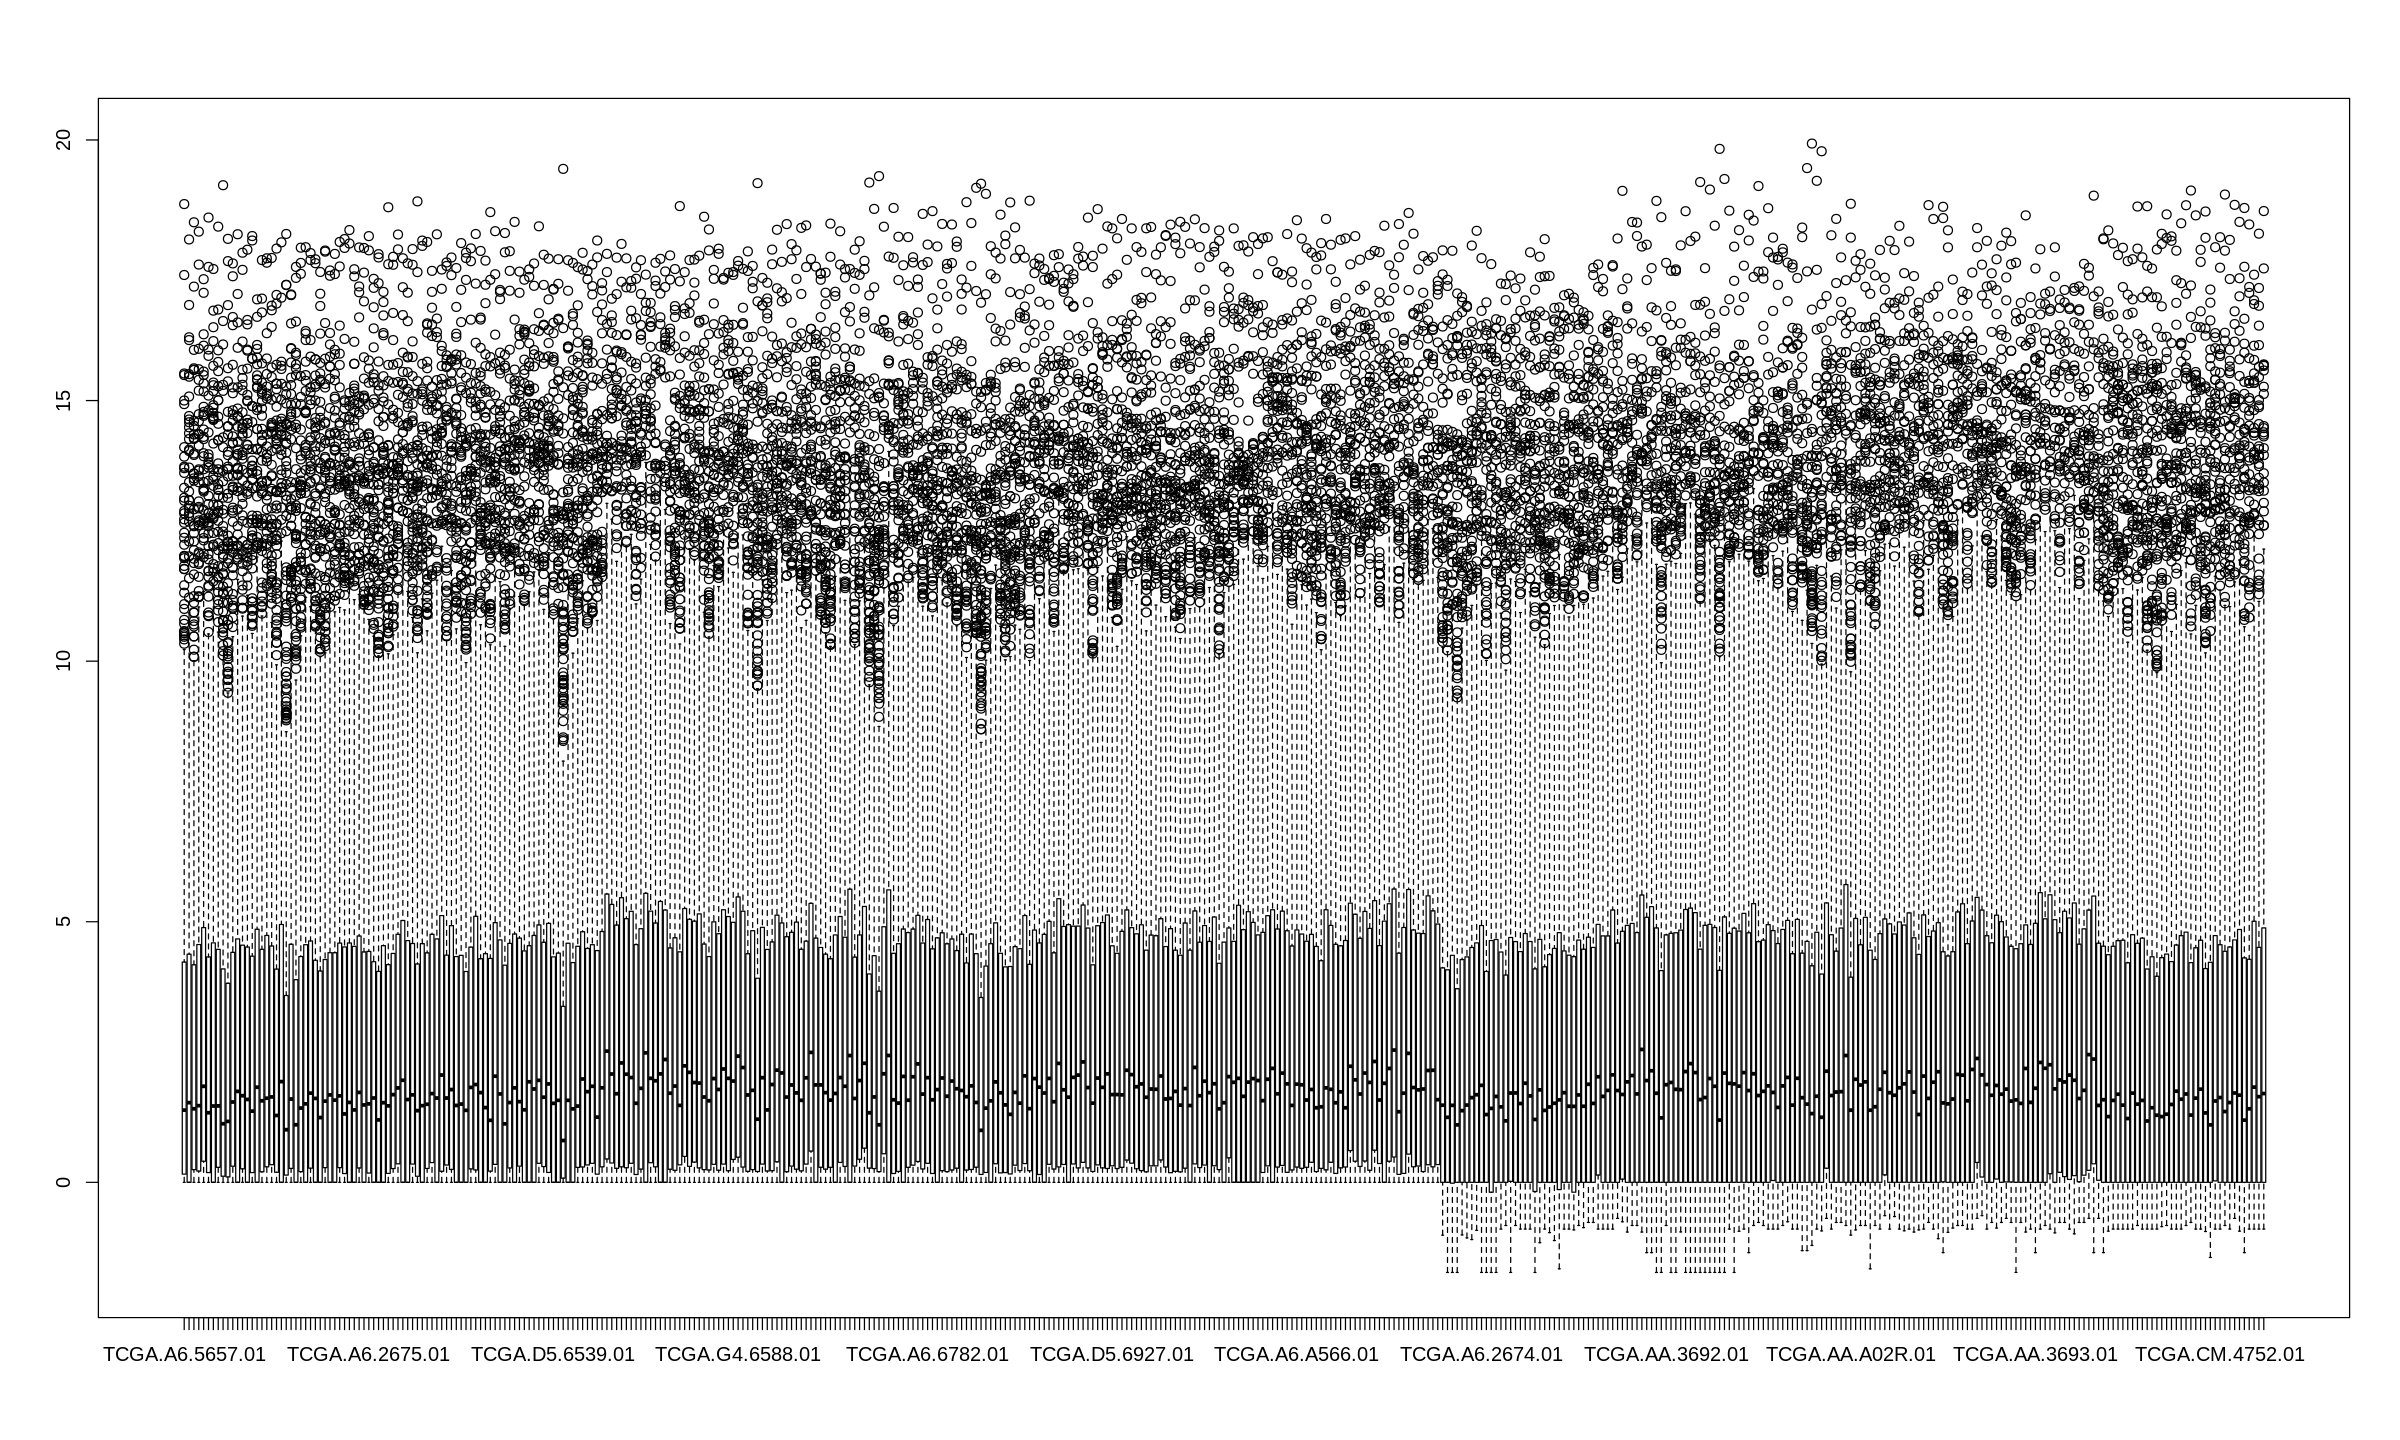

In [3]:
### 3) Log2(x + 1) transformation
COAD.miRNA.log2 <- log2(COAD.pancan.miRNA.mx + 1)
hist(COAD.miRNA.log2)
boxplot(COAD.miRNA.log2)

### 4)Builed ExpressionSet
library(Biobase)
table(Cluster.df$rownames %in% colnames(COAD.miRNA.log2))
sampleID <- Cluster.df$rownames[Cluster.df$rownames %in% colnames(COAD.miRNA.log2)]
Cluster.df.sub <- new("AnnotatedDataFrame",
                      data=Cluster.df[sampleID,])
COAD.miRNA.set <- ExpressionSet(assayData=COAD.miRNA.log2[,sampleID],
                                phenoData=Cluster.df.sub)


Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA

Warning message:
“Zero sample variances detected, have been offset away from zero”

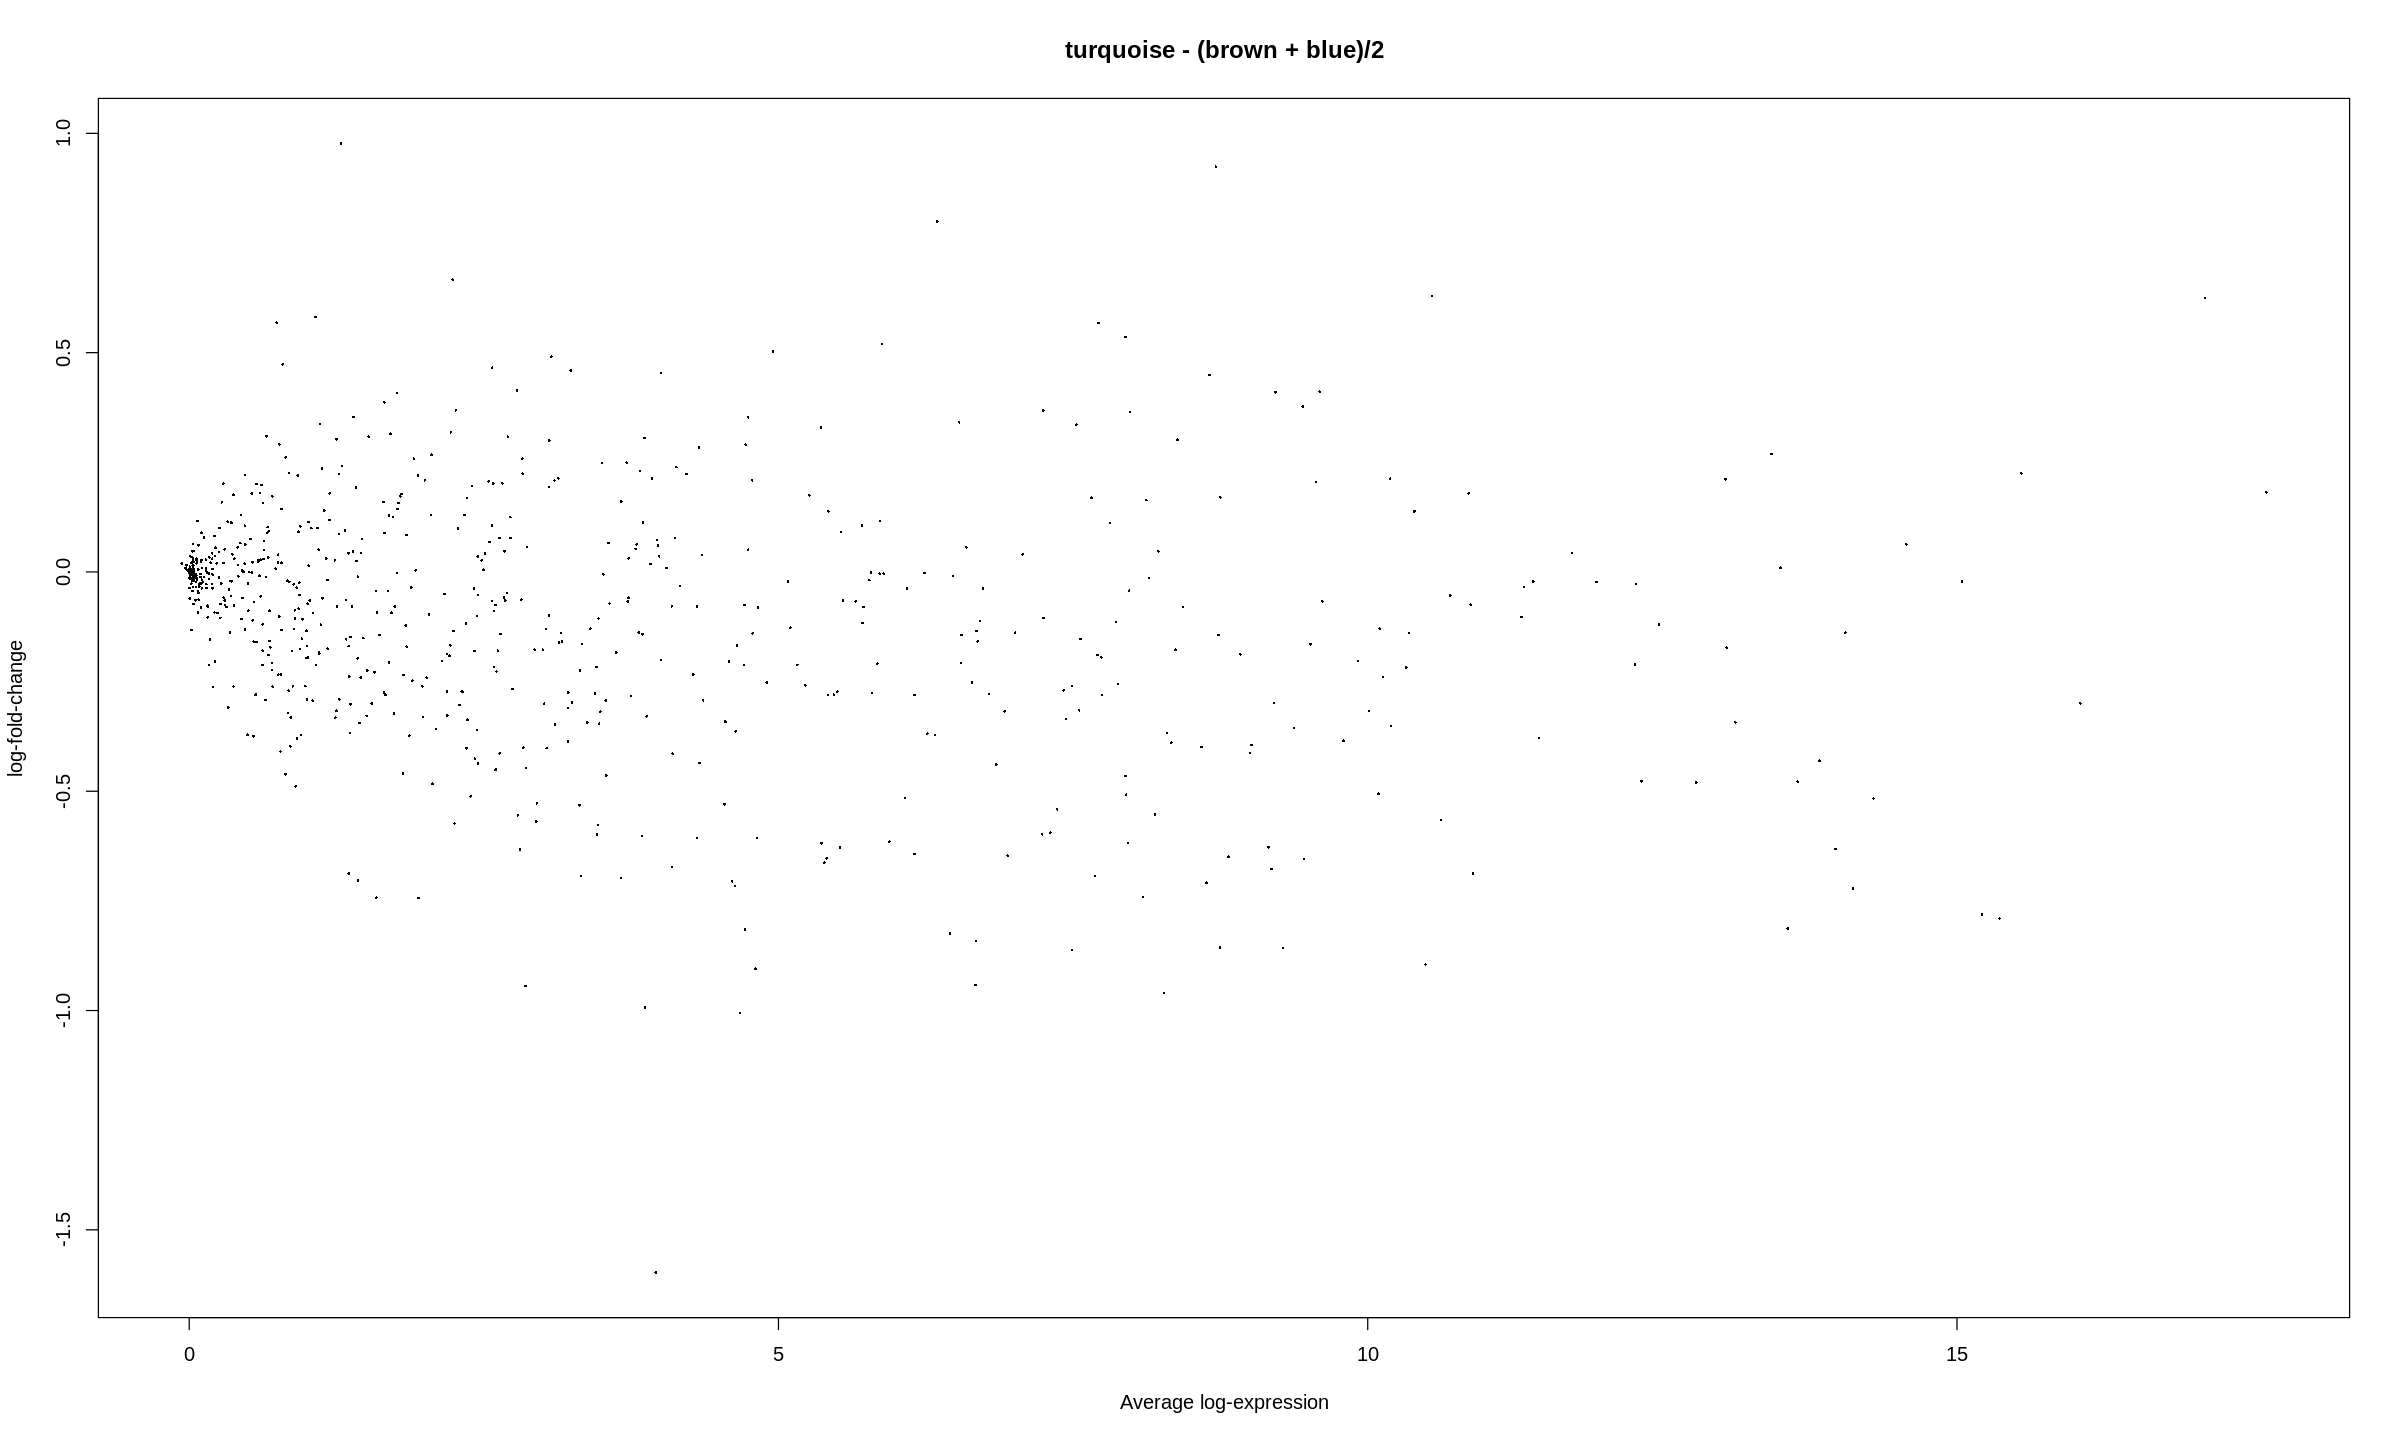

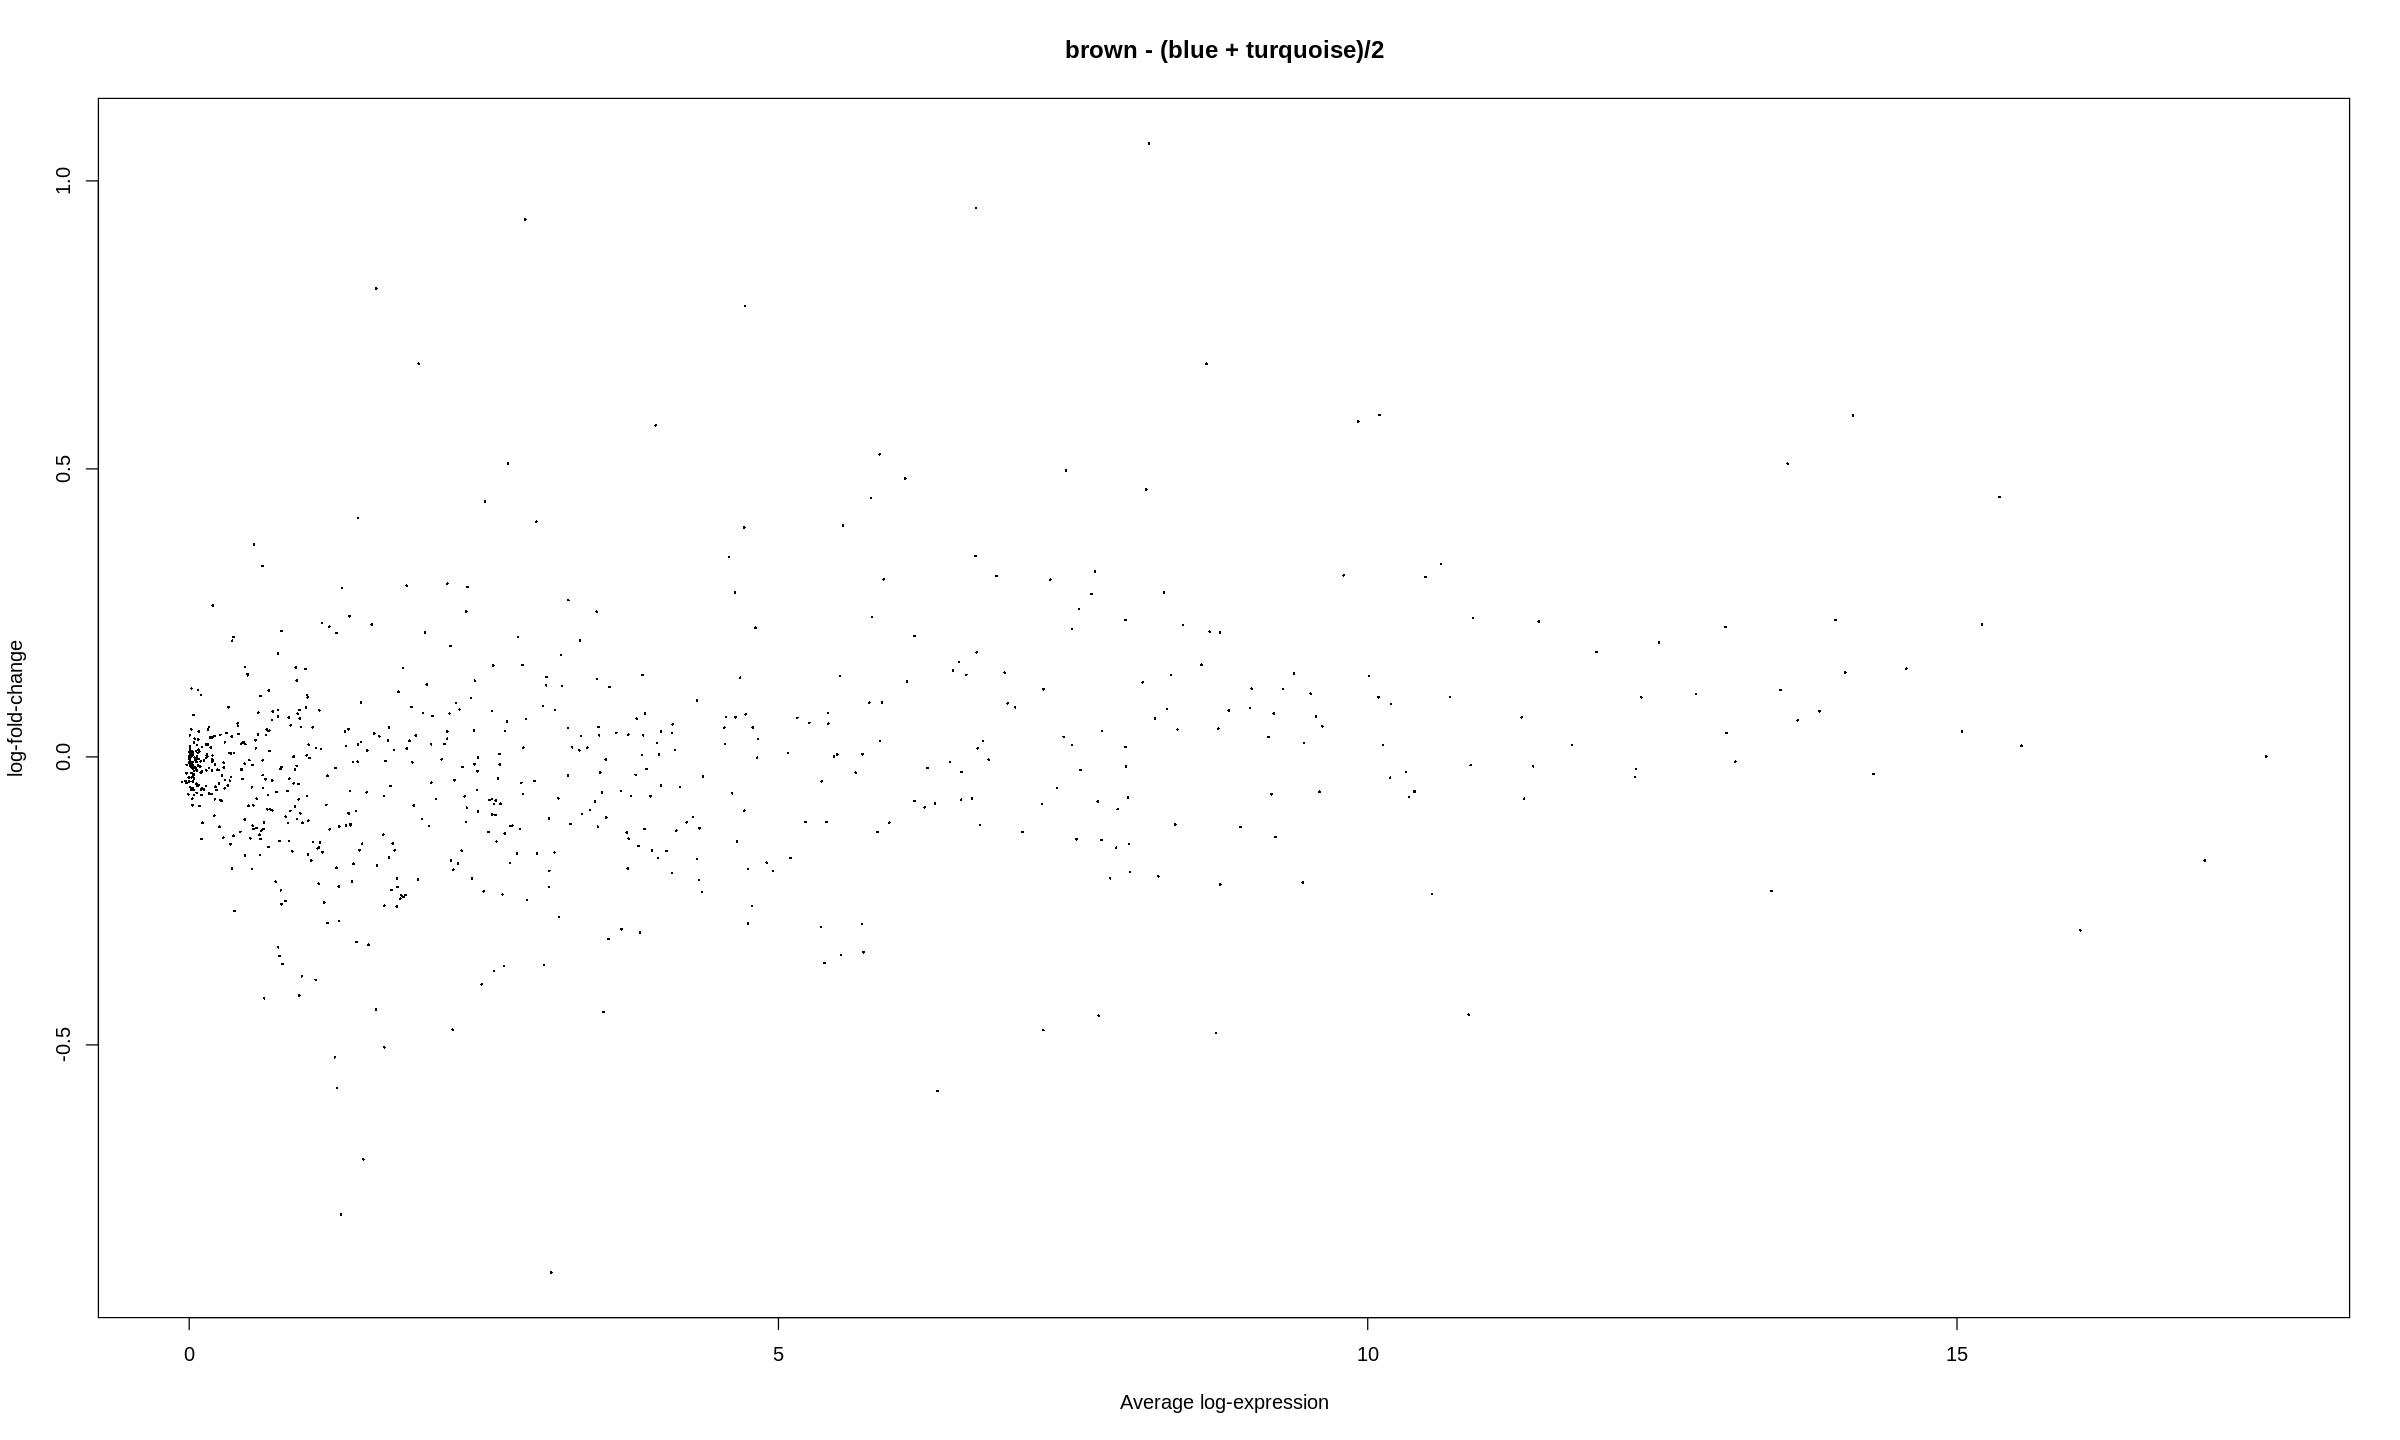

       blue - (brown + turquoise)/2 brown - (blue + turquoise)/2
Down                             45                            2
NotSig                          505                          734
Up                              193                            7
       turquoise - (brown + blue)/2
Down                            193
NotSig                          479
Up                               71

logFC      AveExpr   t         P.Value      adj.P.Val   
hsa-miR-146b-5p -0.6661756 8.6589681 -7.089671 1.133602e-11 8.422665e-09
hsa-miR-32-3p    0.4911089 0.8575745  6.915107 3.264573e-11 1.212789e-08
hsa-miR-4772-3p -0.8179269 2.7046895 -6.772256 7.656859e-11 1.896349e-08
hsa-miR-132-3p  -0.5061231 6.5328173 -6.689879 1.245004e-10 2.312595e-08
hsa-miR-362-5p   0.9175214 3.8674558  6.558747 2.676720e-10 3.977607e-08
hsa-miR-150-5p  -1.0505262 8.1452415 -6.482996 4.145495e-10 4.730841e-08
                B       
hsa-miR-146b-5p 16.10859
hsa-miR-32-3p   15.09456
hsa-miR-4772-3p 14.27787
hsa-miR-132-3p  13.81239
hsa-miR-362-5p  13.07984
hsa-miR-150-5p  12.66144

       blue - (brown + turquoise)/2 brown - (blue + turquoise)/2
Down                             45                            2
NotSig                          505                          734
Up                              193                            7
       turquoise - (brown + blue)/2
Down                            193
NotSig                          479
Up                               71

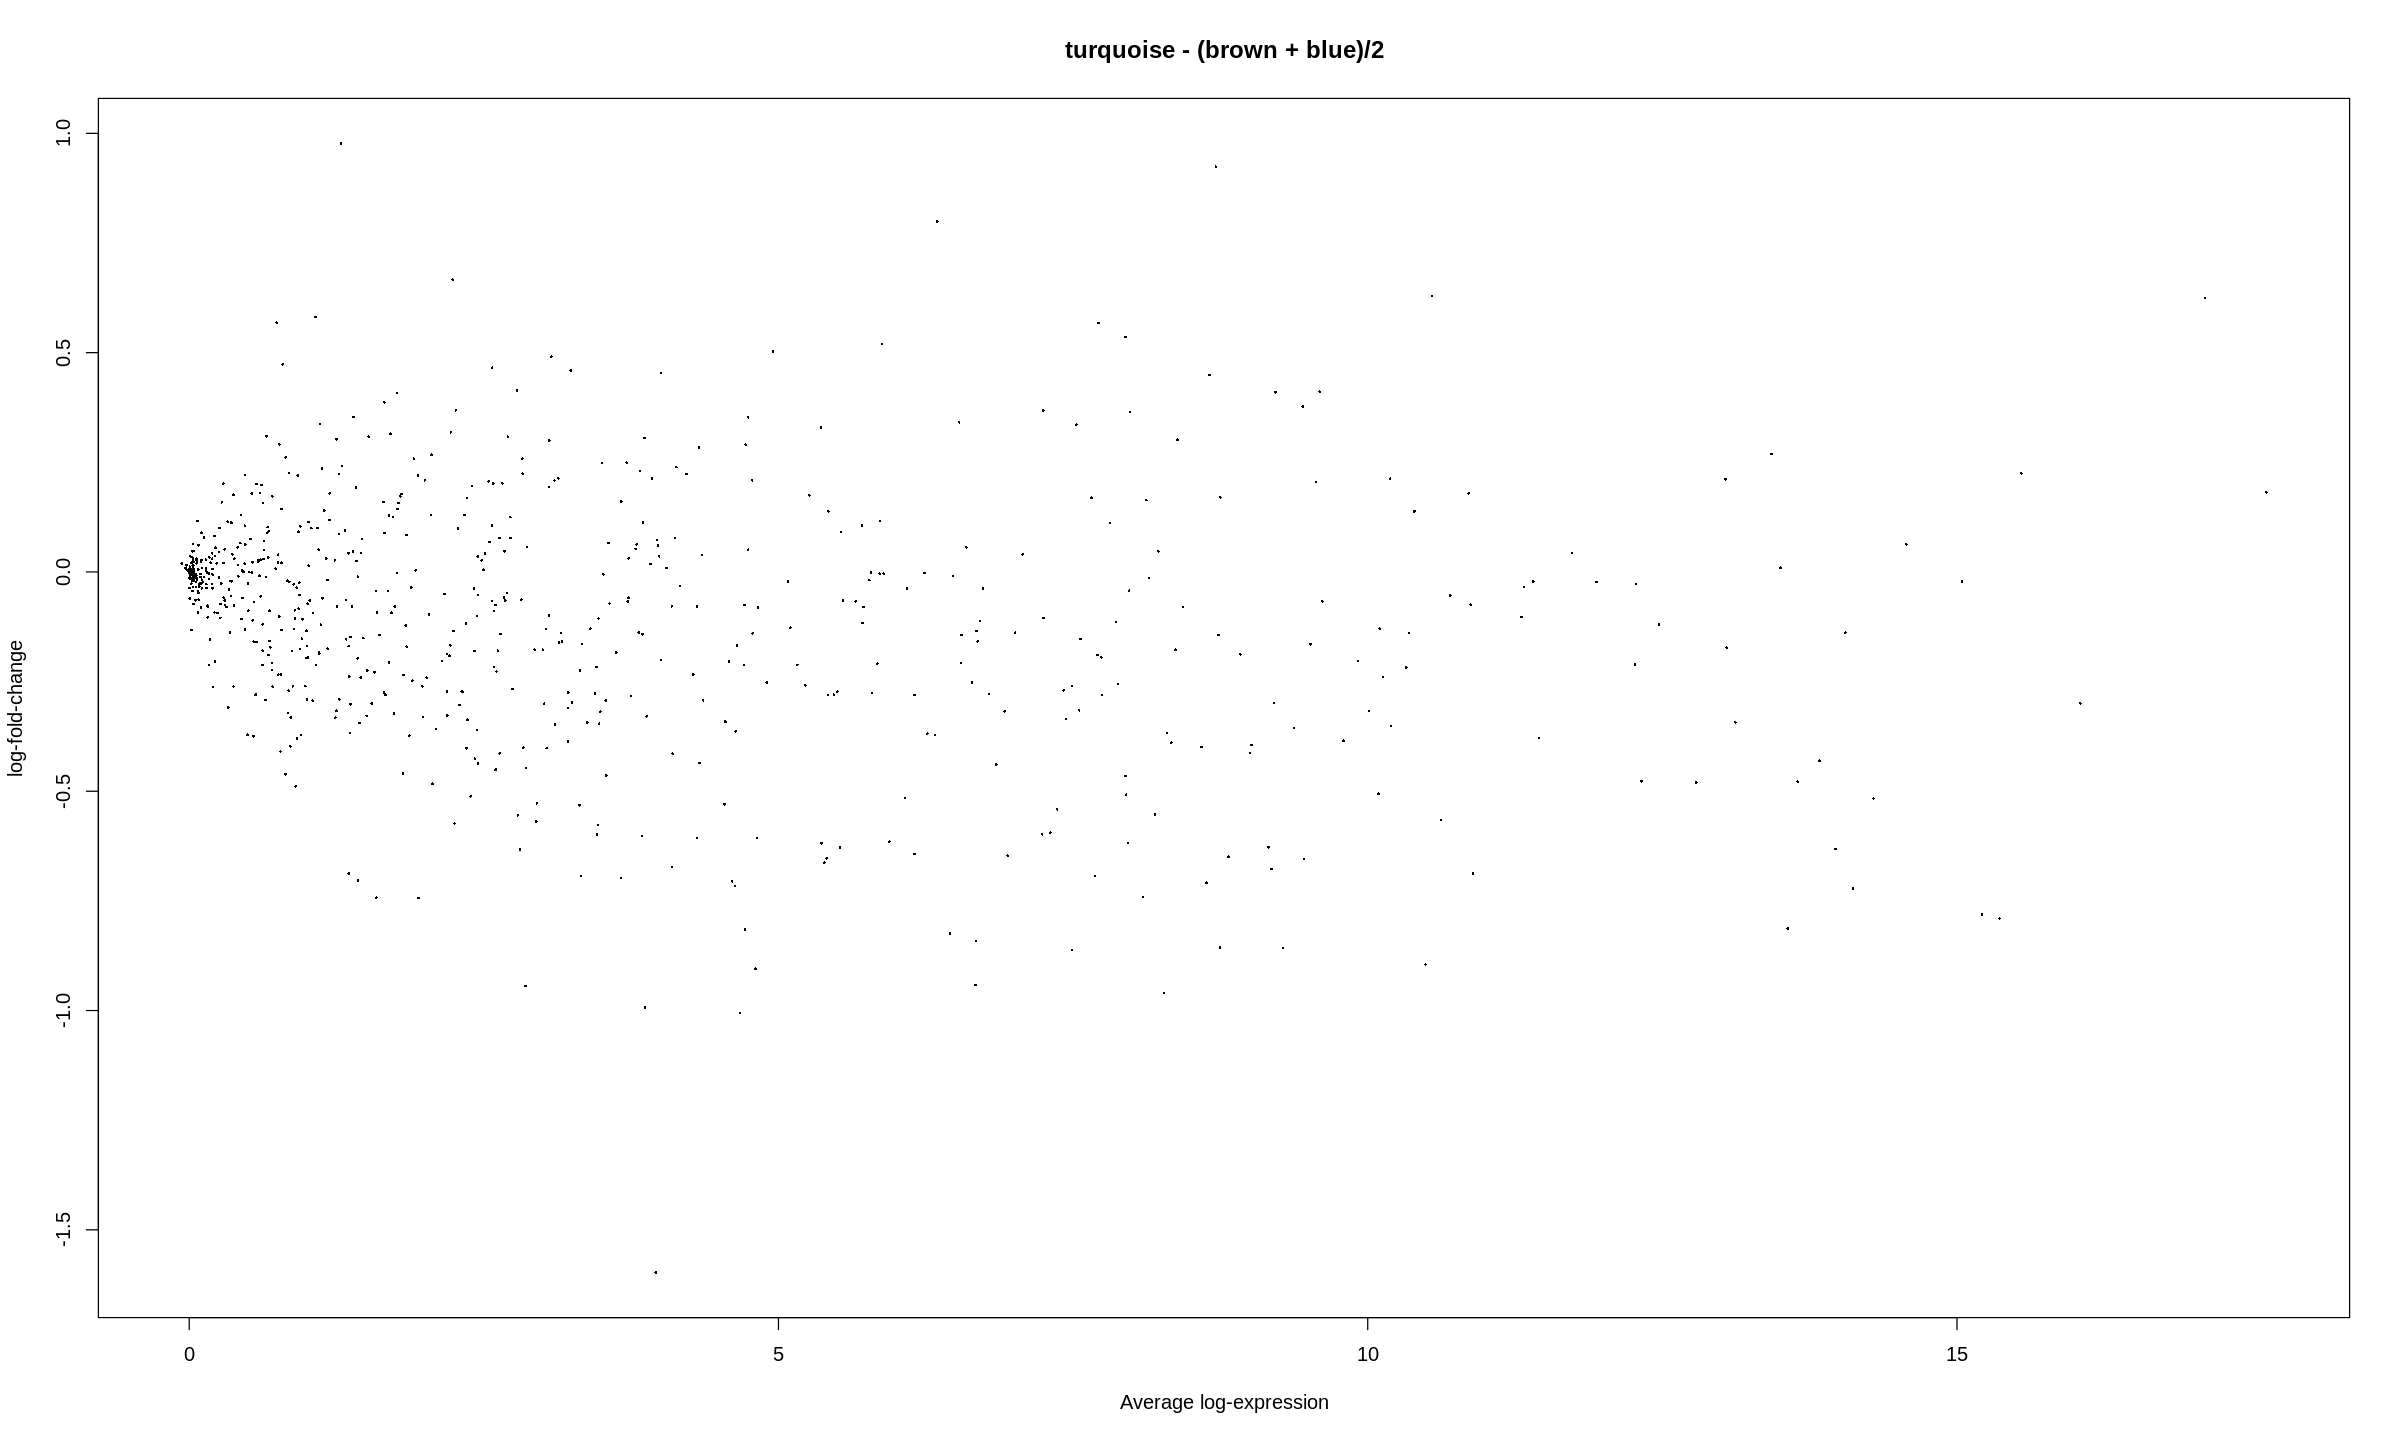

In [4]:
## 5) differential miRNA analysis limma version
## Several Groups experiment design
library(limma)
#Cluster.df.sub@data$dynamicColors
f.miRNA <- factor(Cluster.df.sub@data$dynamicColors, levels=c("blue","brown","turquoise","yellow"))
design.miRNA <- model.matrix(~0+f.miRNA)
colnames(design.miRNA) <- c("blue","brown","turquoise","yellow")
# fit the linear model 
fit.miRNA <- lmFit(COAD.miRNA.set, design.miRNA)
contrast.matrix.miRNA <- makeContrasts(blue-(brown+turquoise)/2, 
                                       brown-(blue+turquoise)/2,
                                       turquoise-(brown+blue)/2,
                                       levels=design.miRNA)

# fit the contrasts
fit.miRNA.2 <- contrasts.fit(fit.miRNA, contrast.matrix.miRNA)
fit.miRNA.2 <- eBayes(fit.miRNA.2)
# Check out ploting
plotMD(fit.miRNA.2)
plotMD(fit.miRNA.2, column = 2)
plotMD(fit.miRNA.2, column = 3)

### 6) Set up cutoff for top DE genes
adjPvalueCutoff <- 0.01
logFCcutoff <- 0.5
summary(decideTests(fit.miRNA.2))
number = 100
miRNA.blue <- topTable(fit.miRNA.2, num=number, coef="blue - (brown + turquoise)/2")
miRNA.brown <- topTable(fit.miRNA.2, num=number, coef="brown - (blue + turquoise)/2")
miRNA.turquoise <- topTable(fit.miRNA.2, num=number, coef="turquoise - (brown + blue)/2")
head(miRNA.blue)
# look at the numbers of DM CpGs at FDR < 0.05
summary(decideTests(fit.miRNA.2))


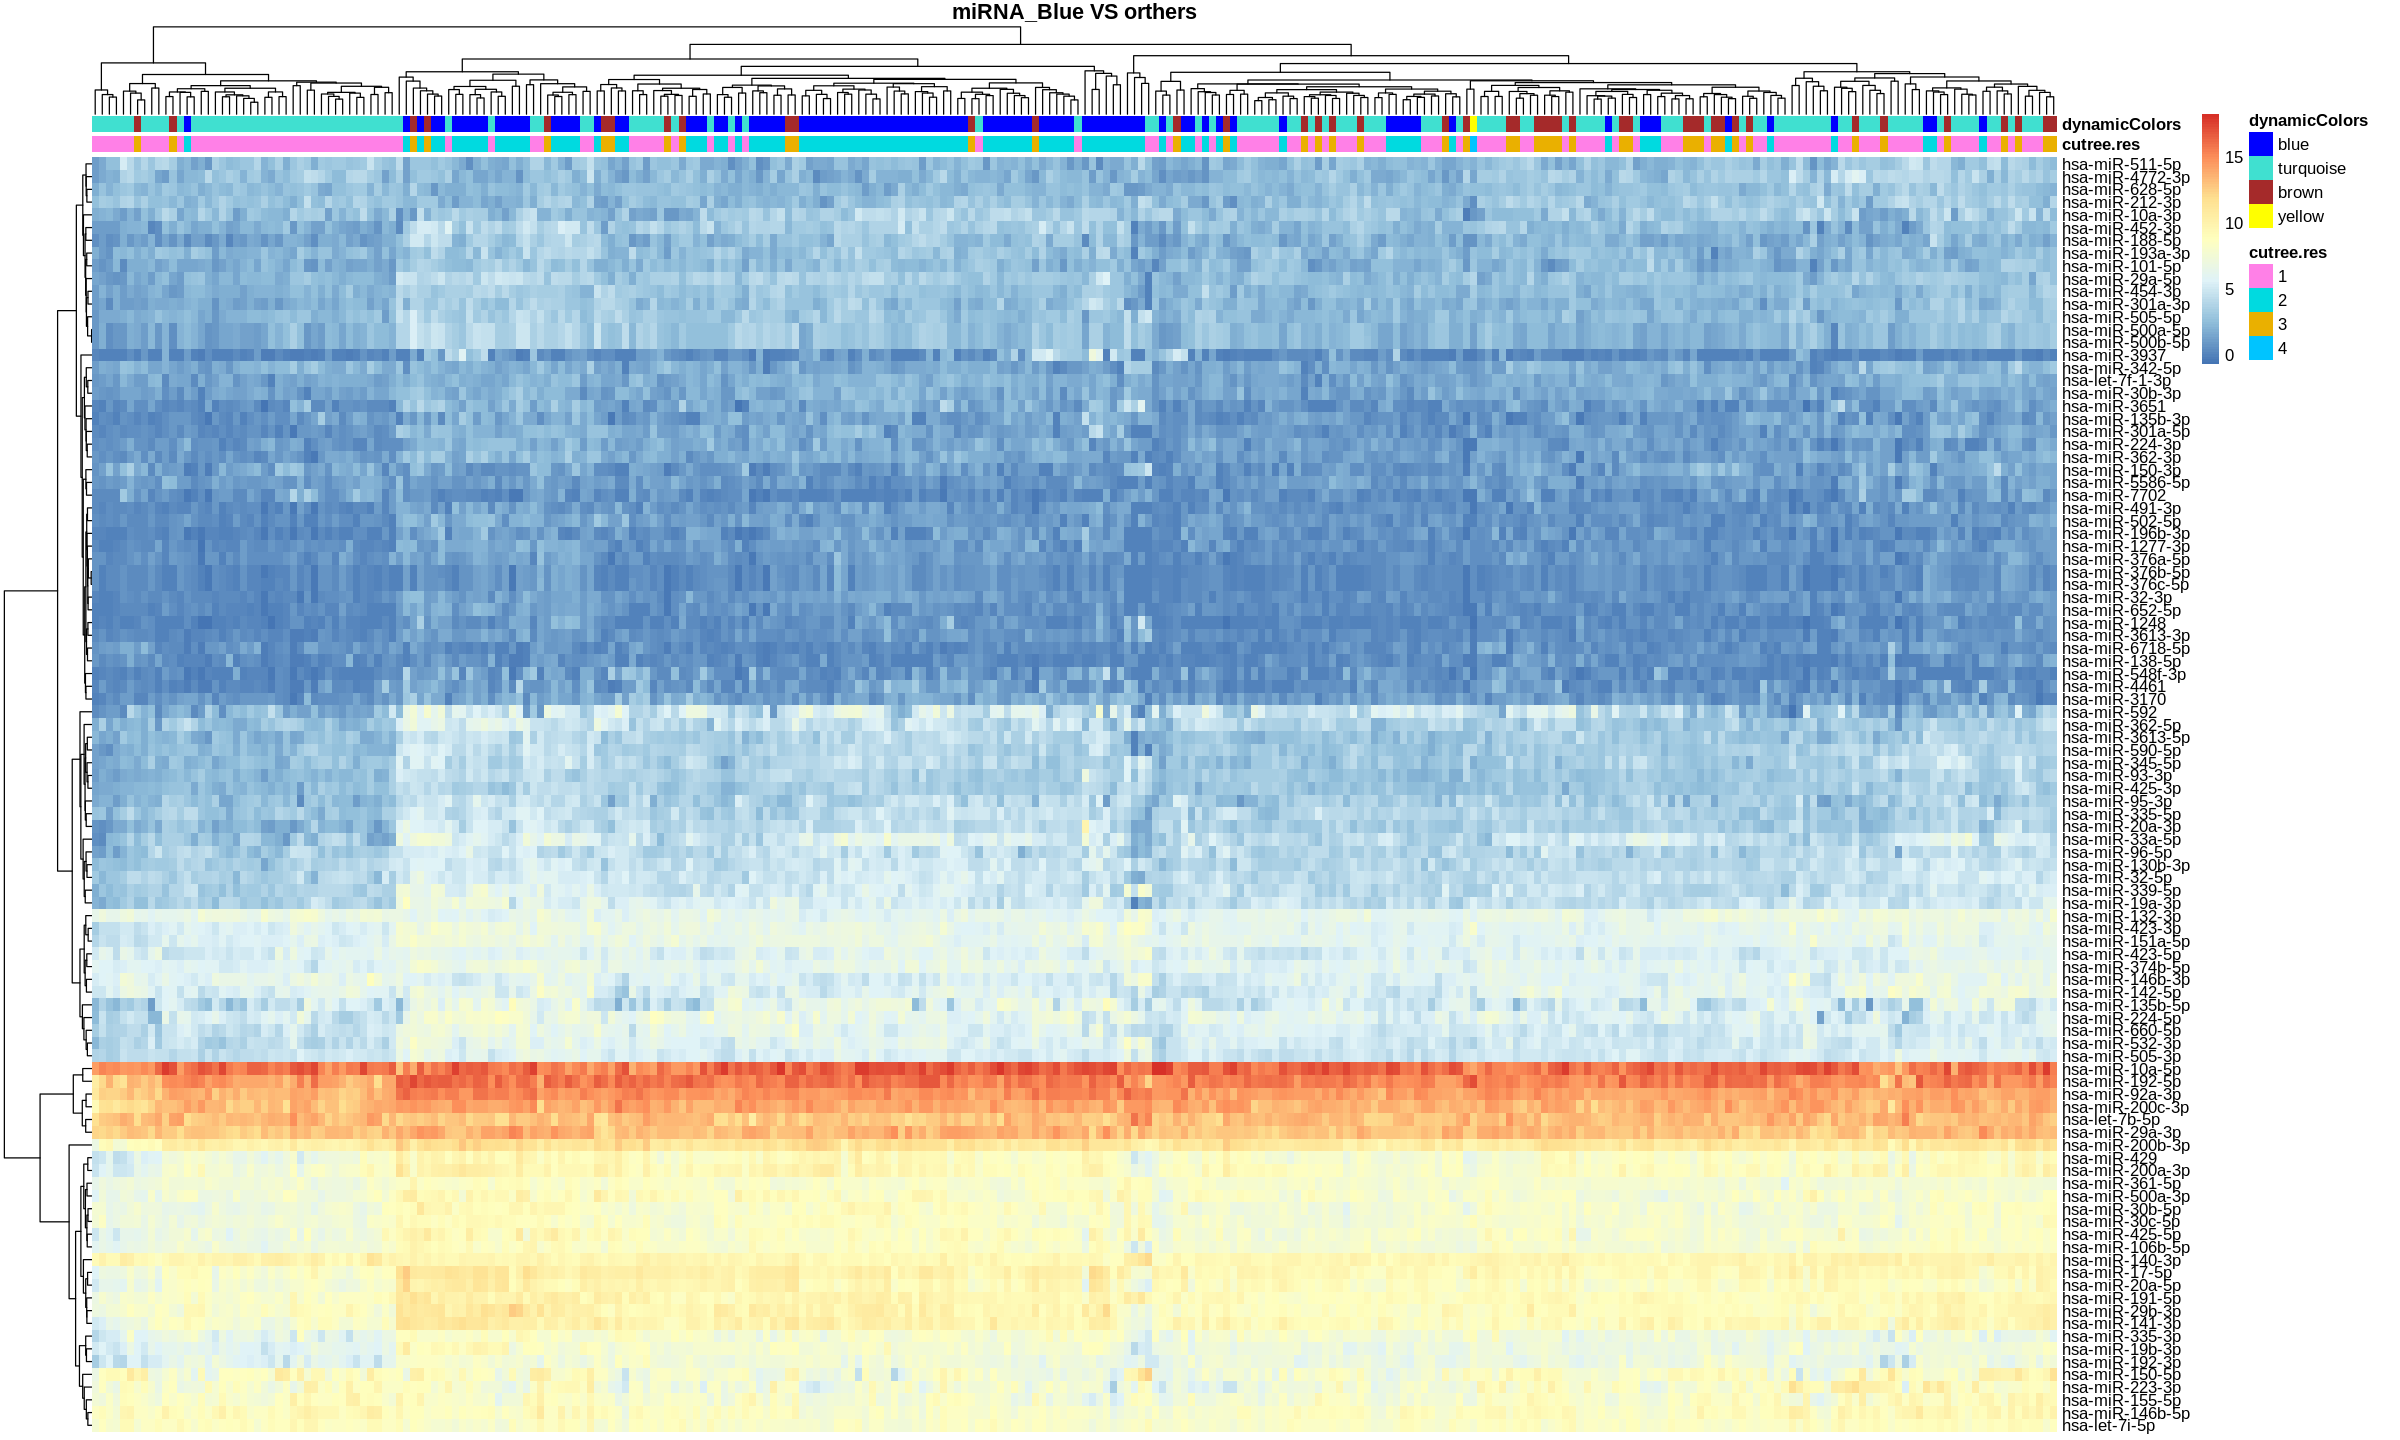

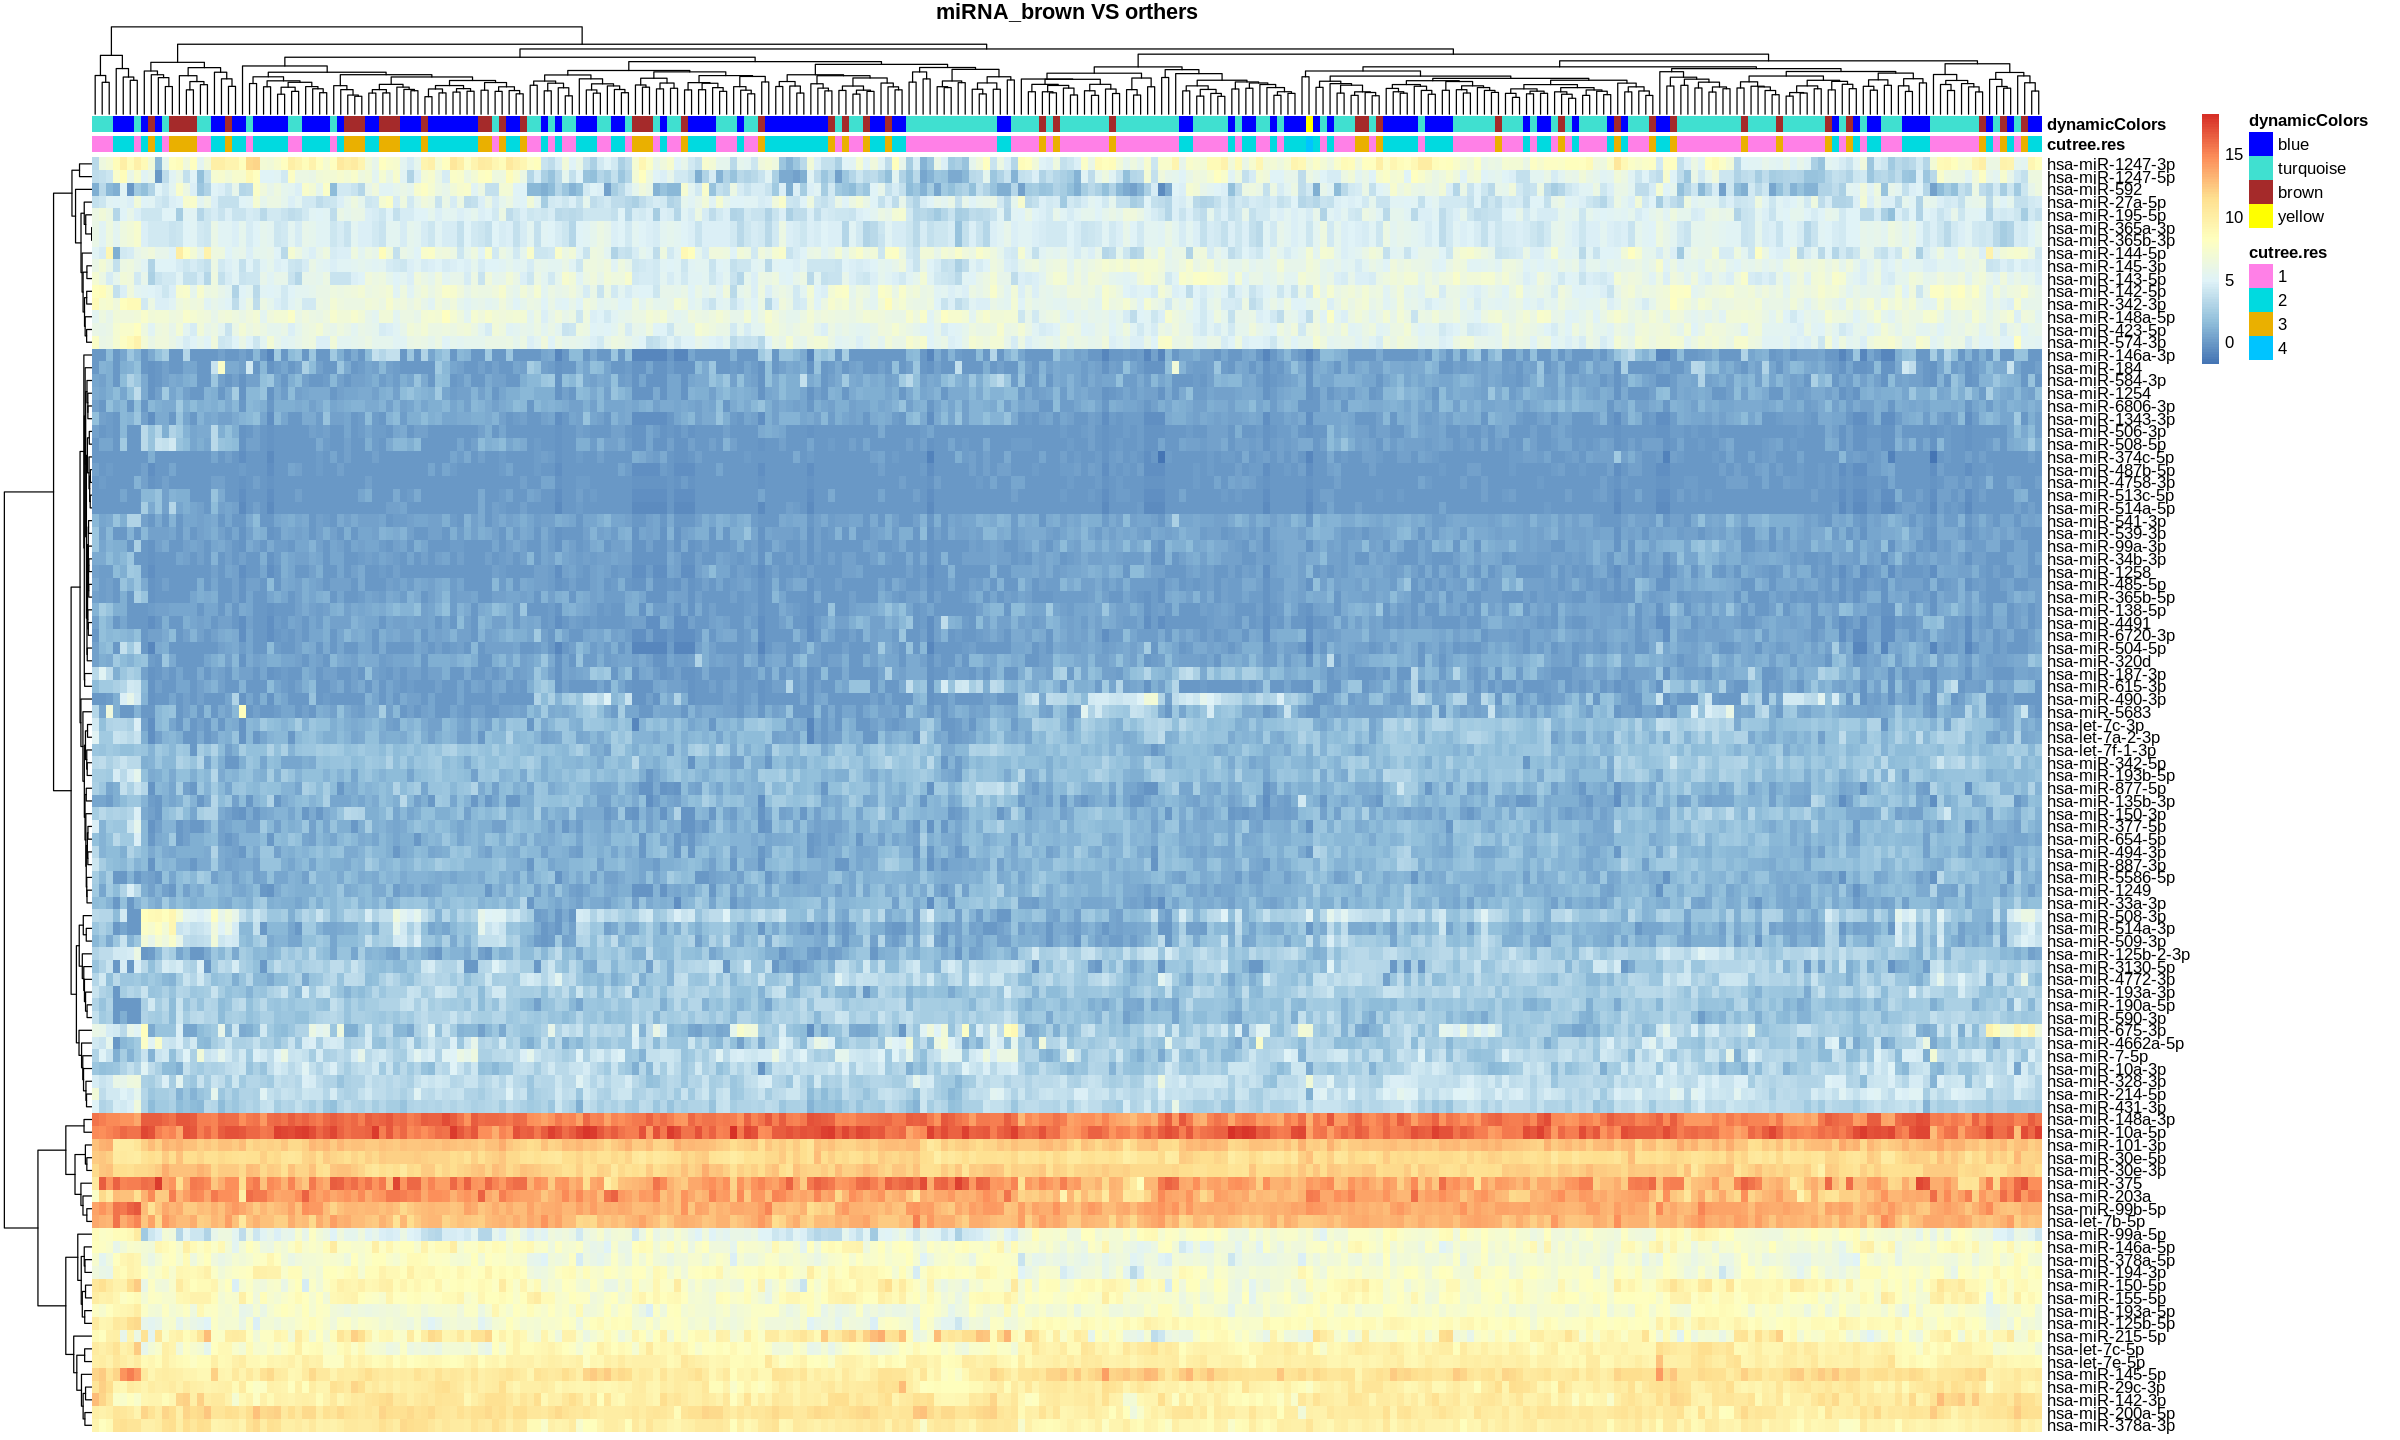

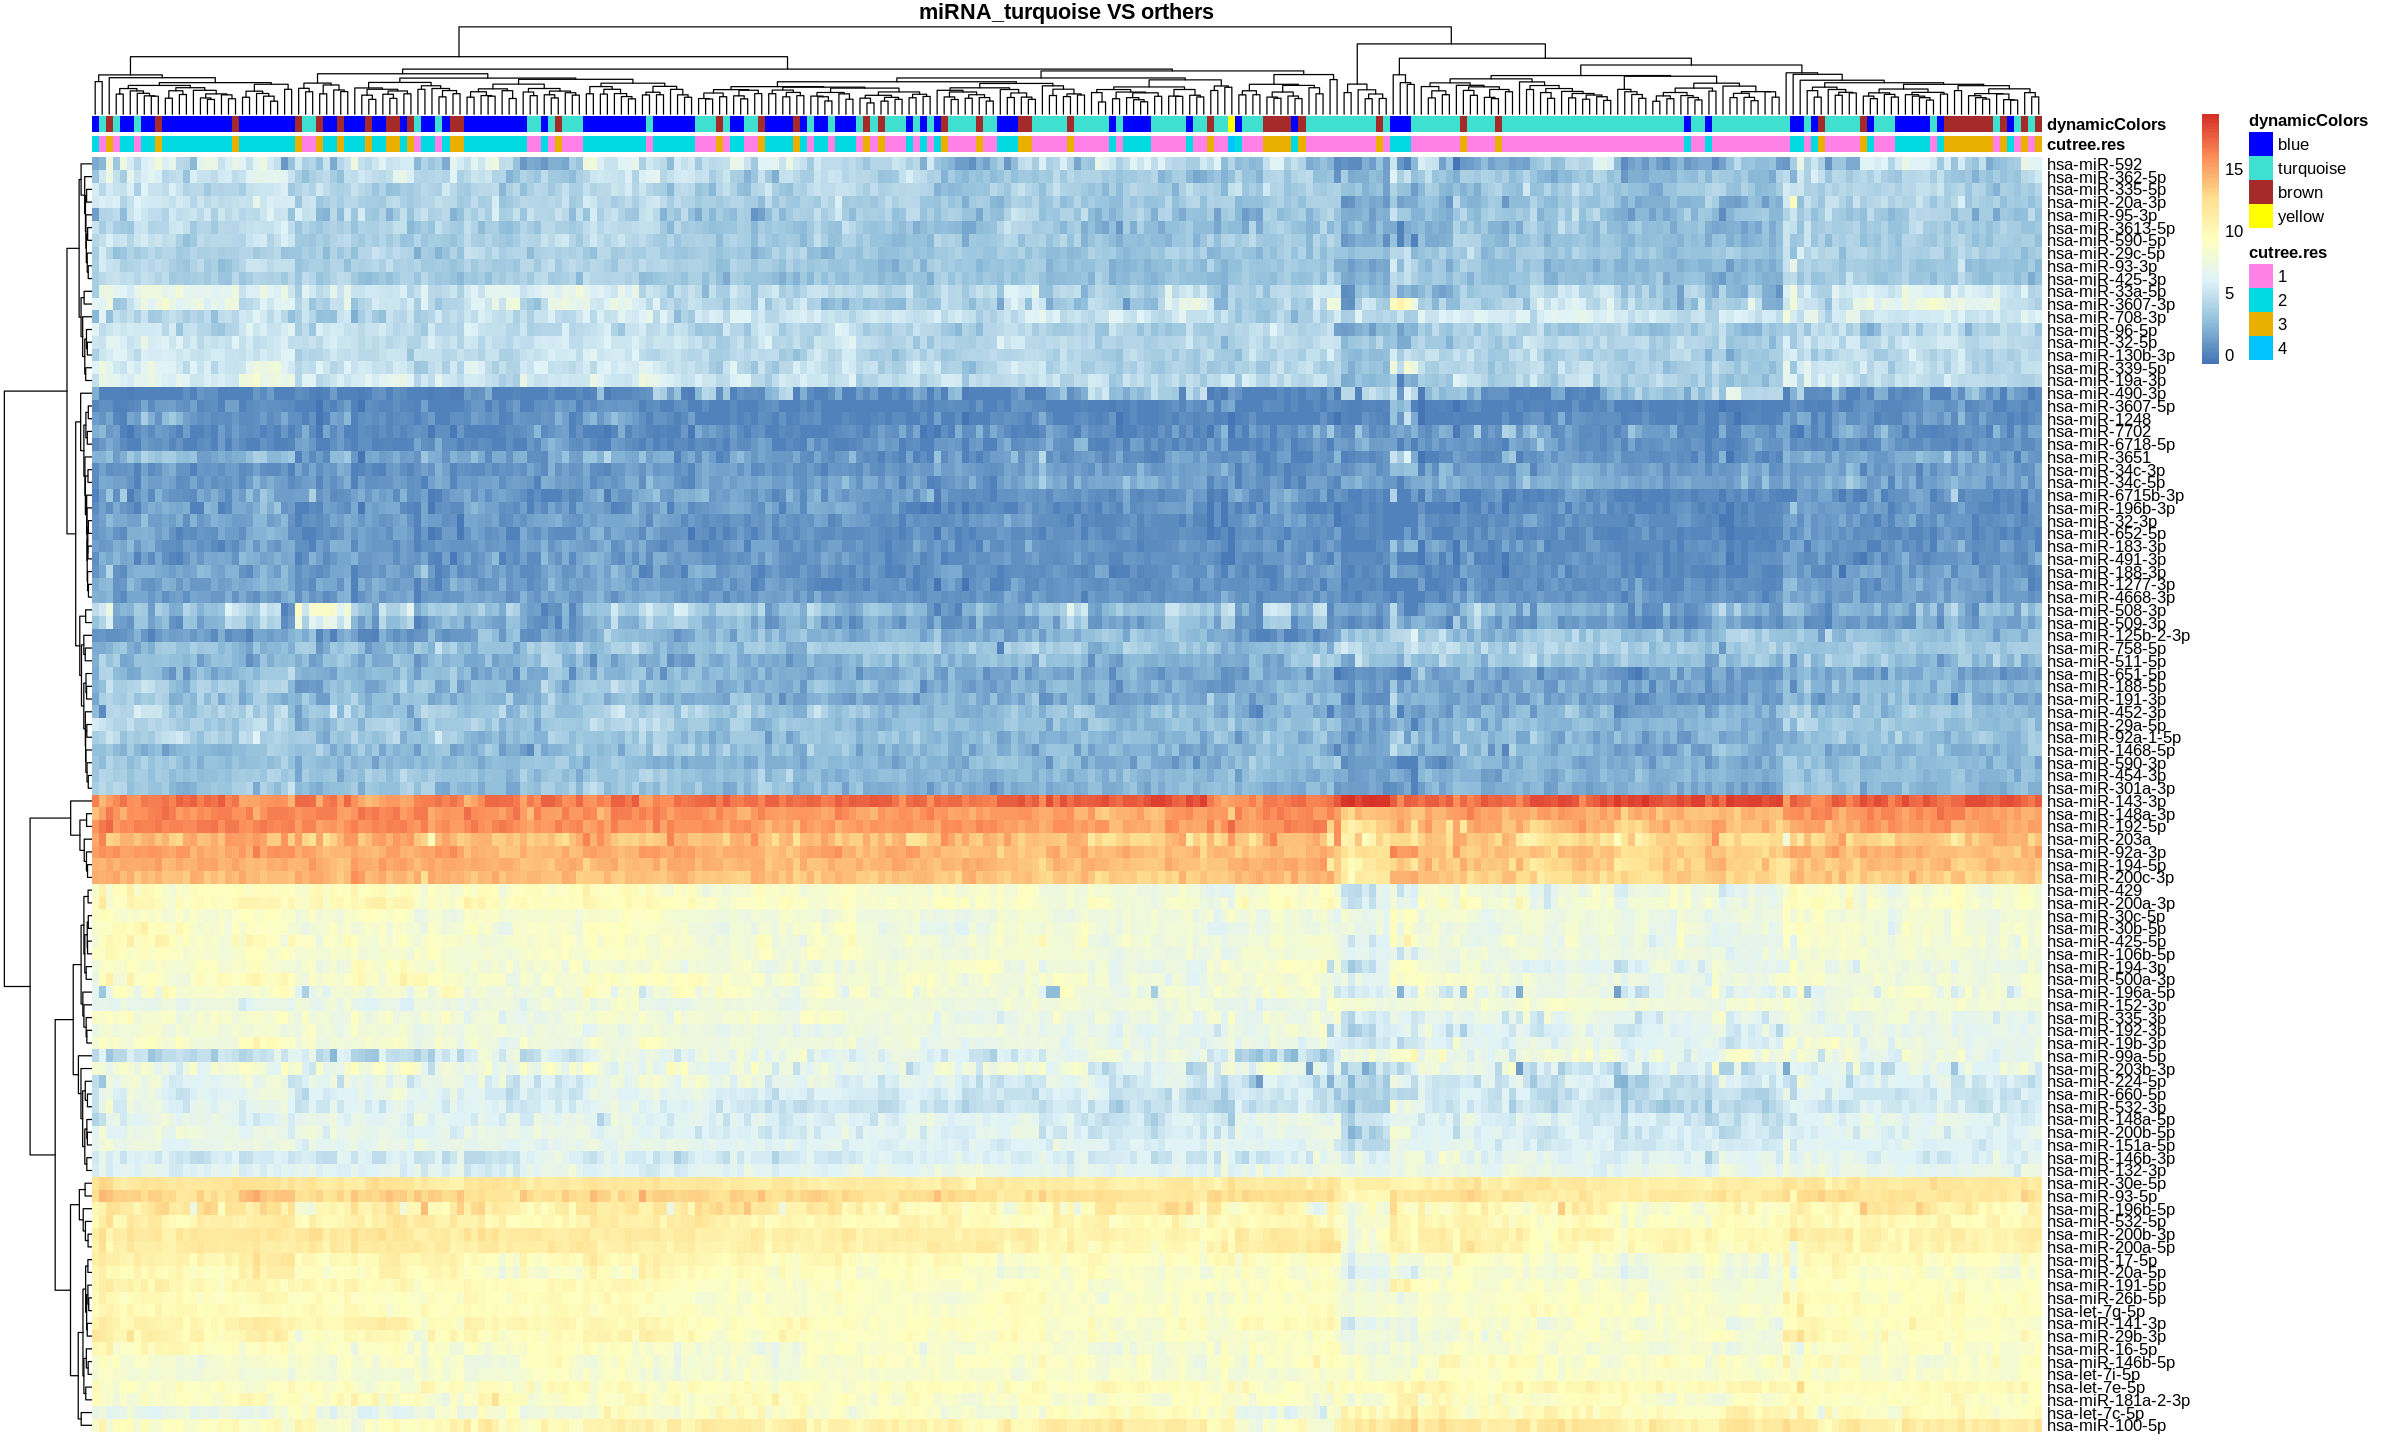

In [5]:
## 7) Heatmap ploting
ann_colors = list(dynamicColors = c(blue = "blue",turquoise = "turquoise", 
                                    brown = "brown", yellow = "yellow"))
options(repr.plot.width=20, repr.plot.height=12)
pheatmap::pheatmap(COAD.miRNA.set[rownames(miRNA.blue),],annotation_col = pData(COAD.miRNA.set)[,1:2],show_colnames = F,
                   main = "miRNA_Blue VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.miRNA.set[rownames(miRNA.brown),],annotation_col = pData(COAD.miRNA.set)[,1:2],show_colnames = F,
                   main = "miRNA_brown VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.miRNA.set[rownames(miRNA.turquoise),],annotation_col = pData(COAD.miRNA.set)[,1:2],show_colnames = F,
                   main = "miRNA_turquoise VS orthers",annotation_colors = ann_colors)


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.00000 -0.39813 -0.09946 -0.09715  0.22203  2.00000 

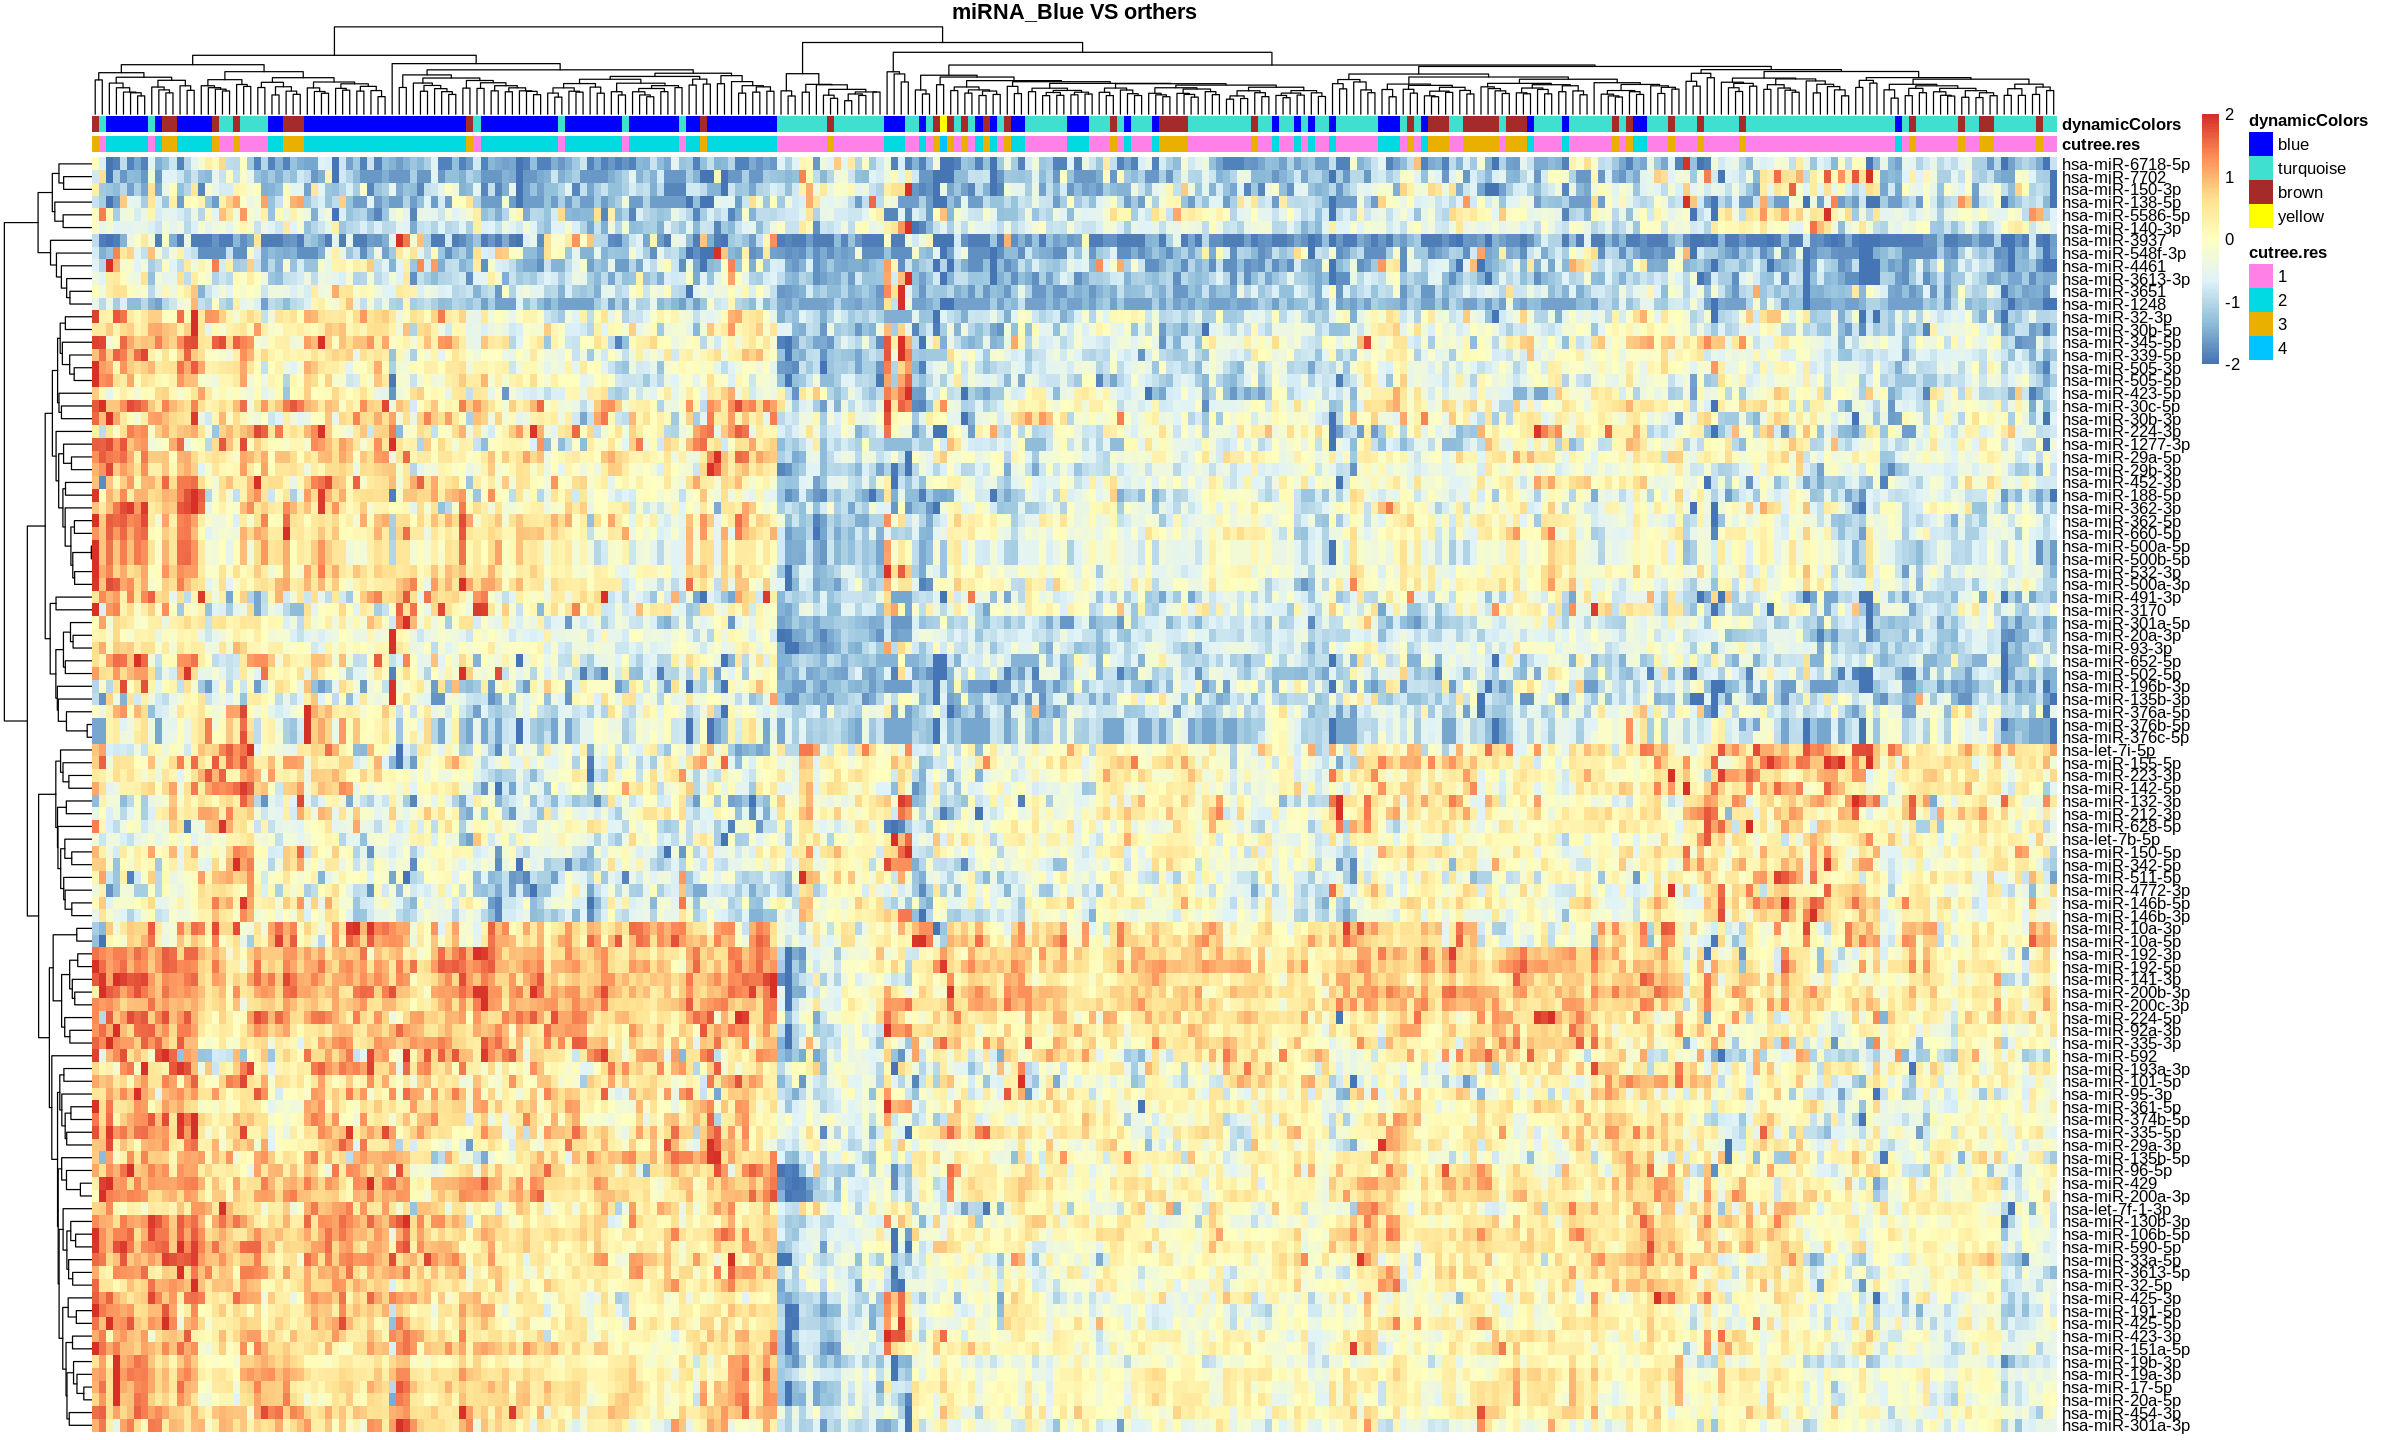

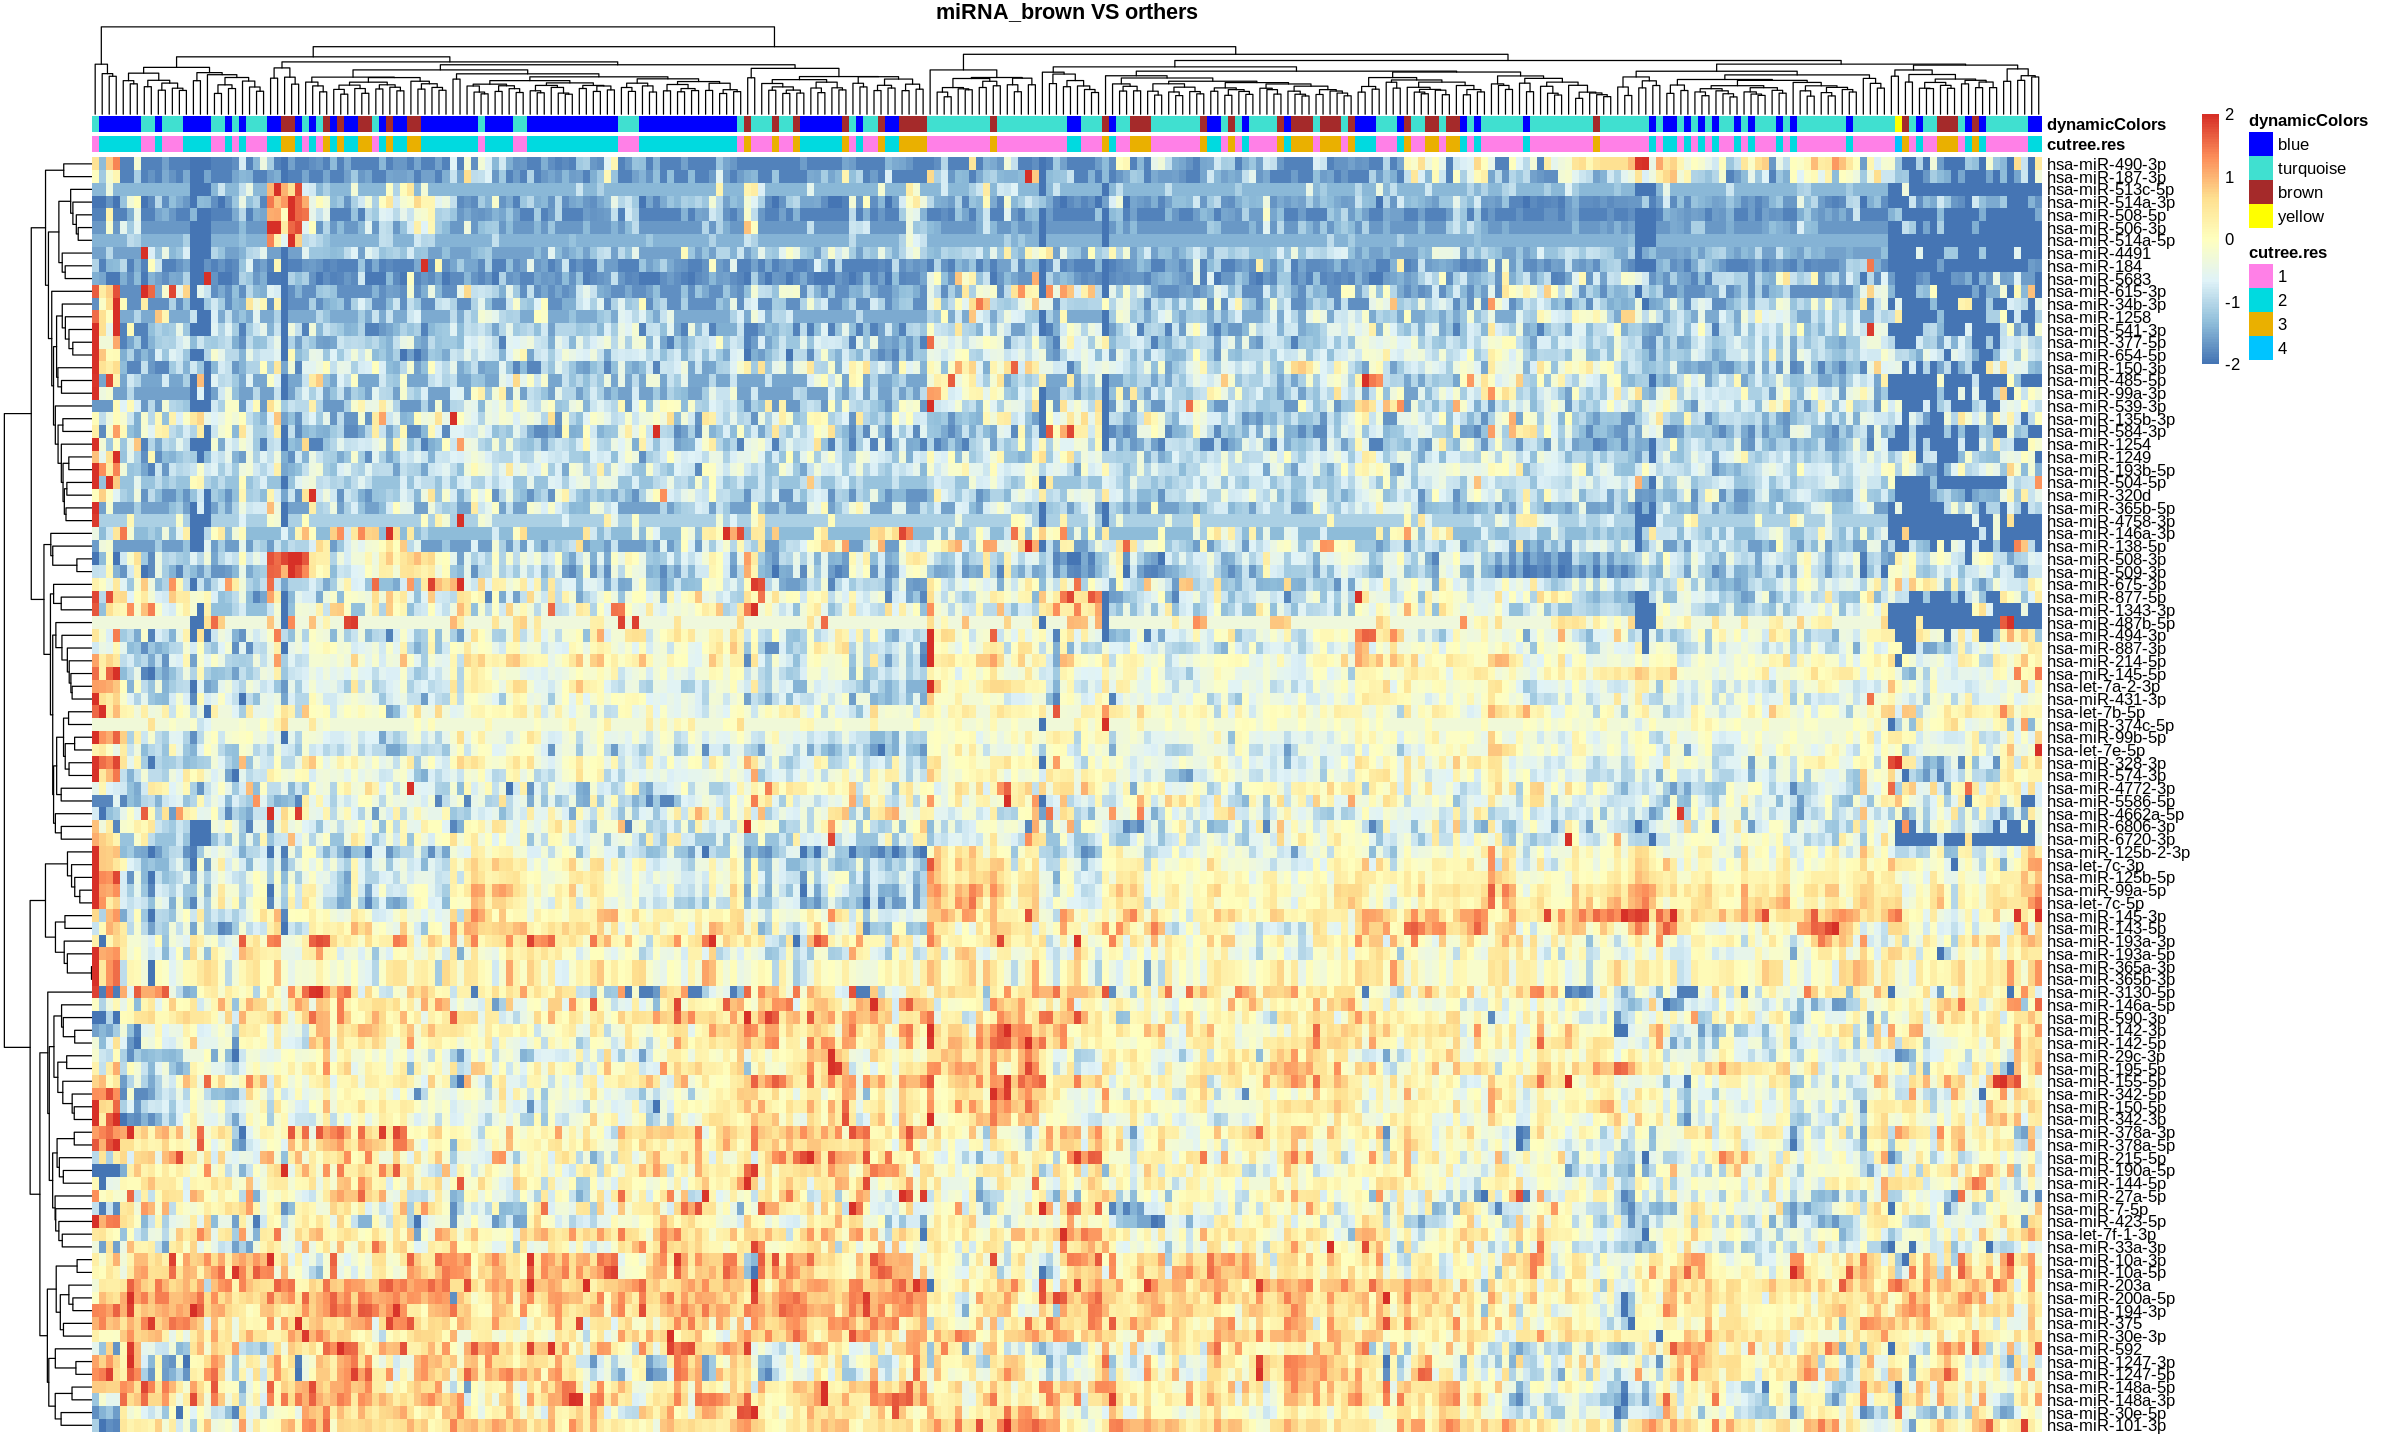

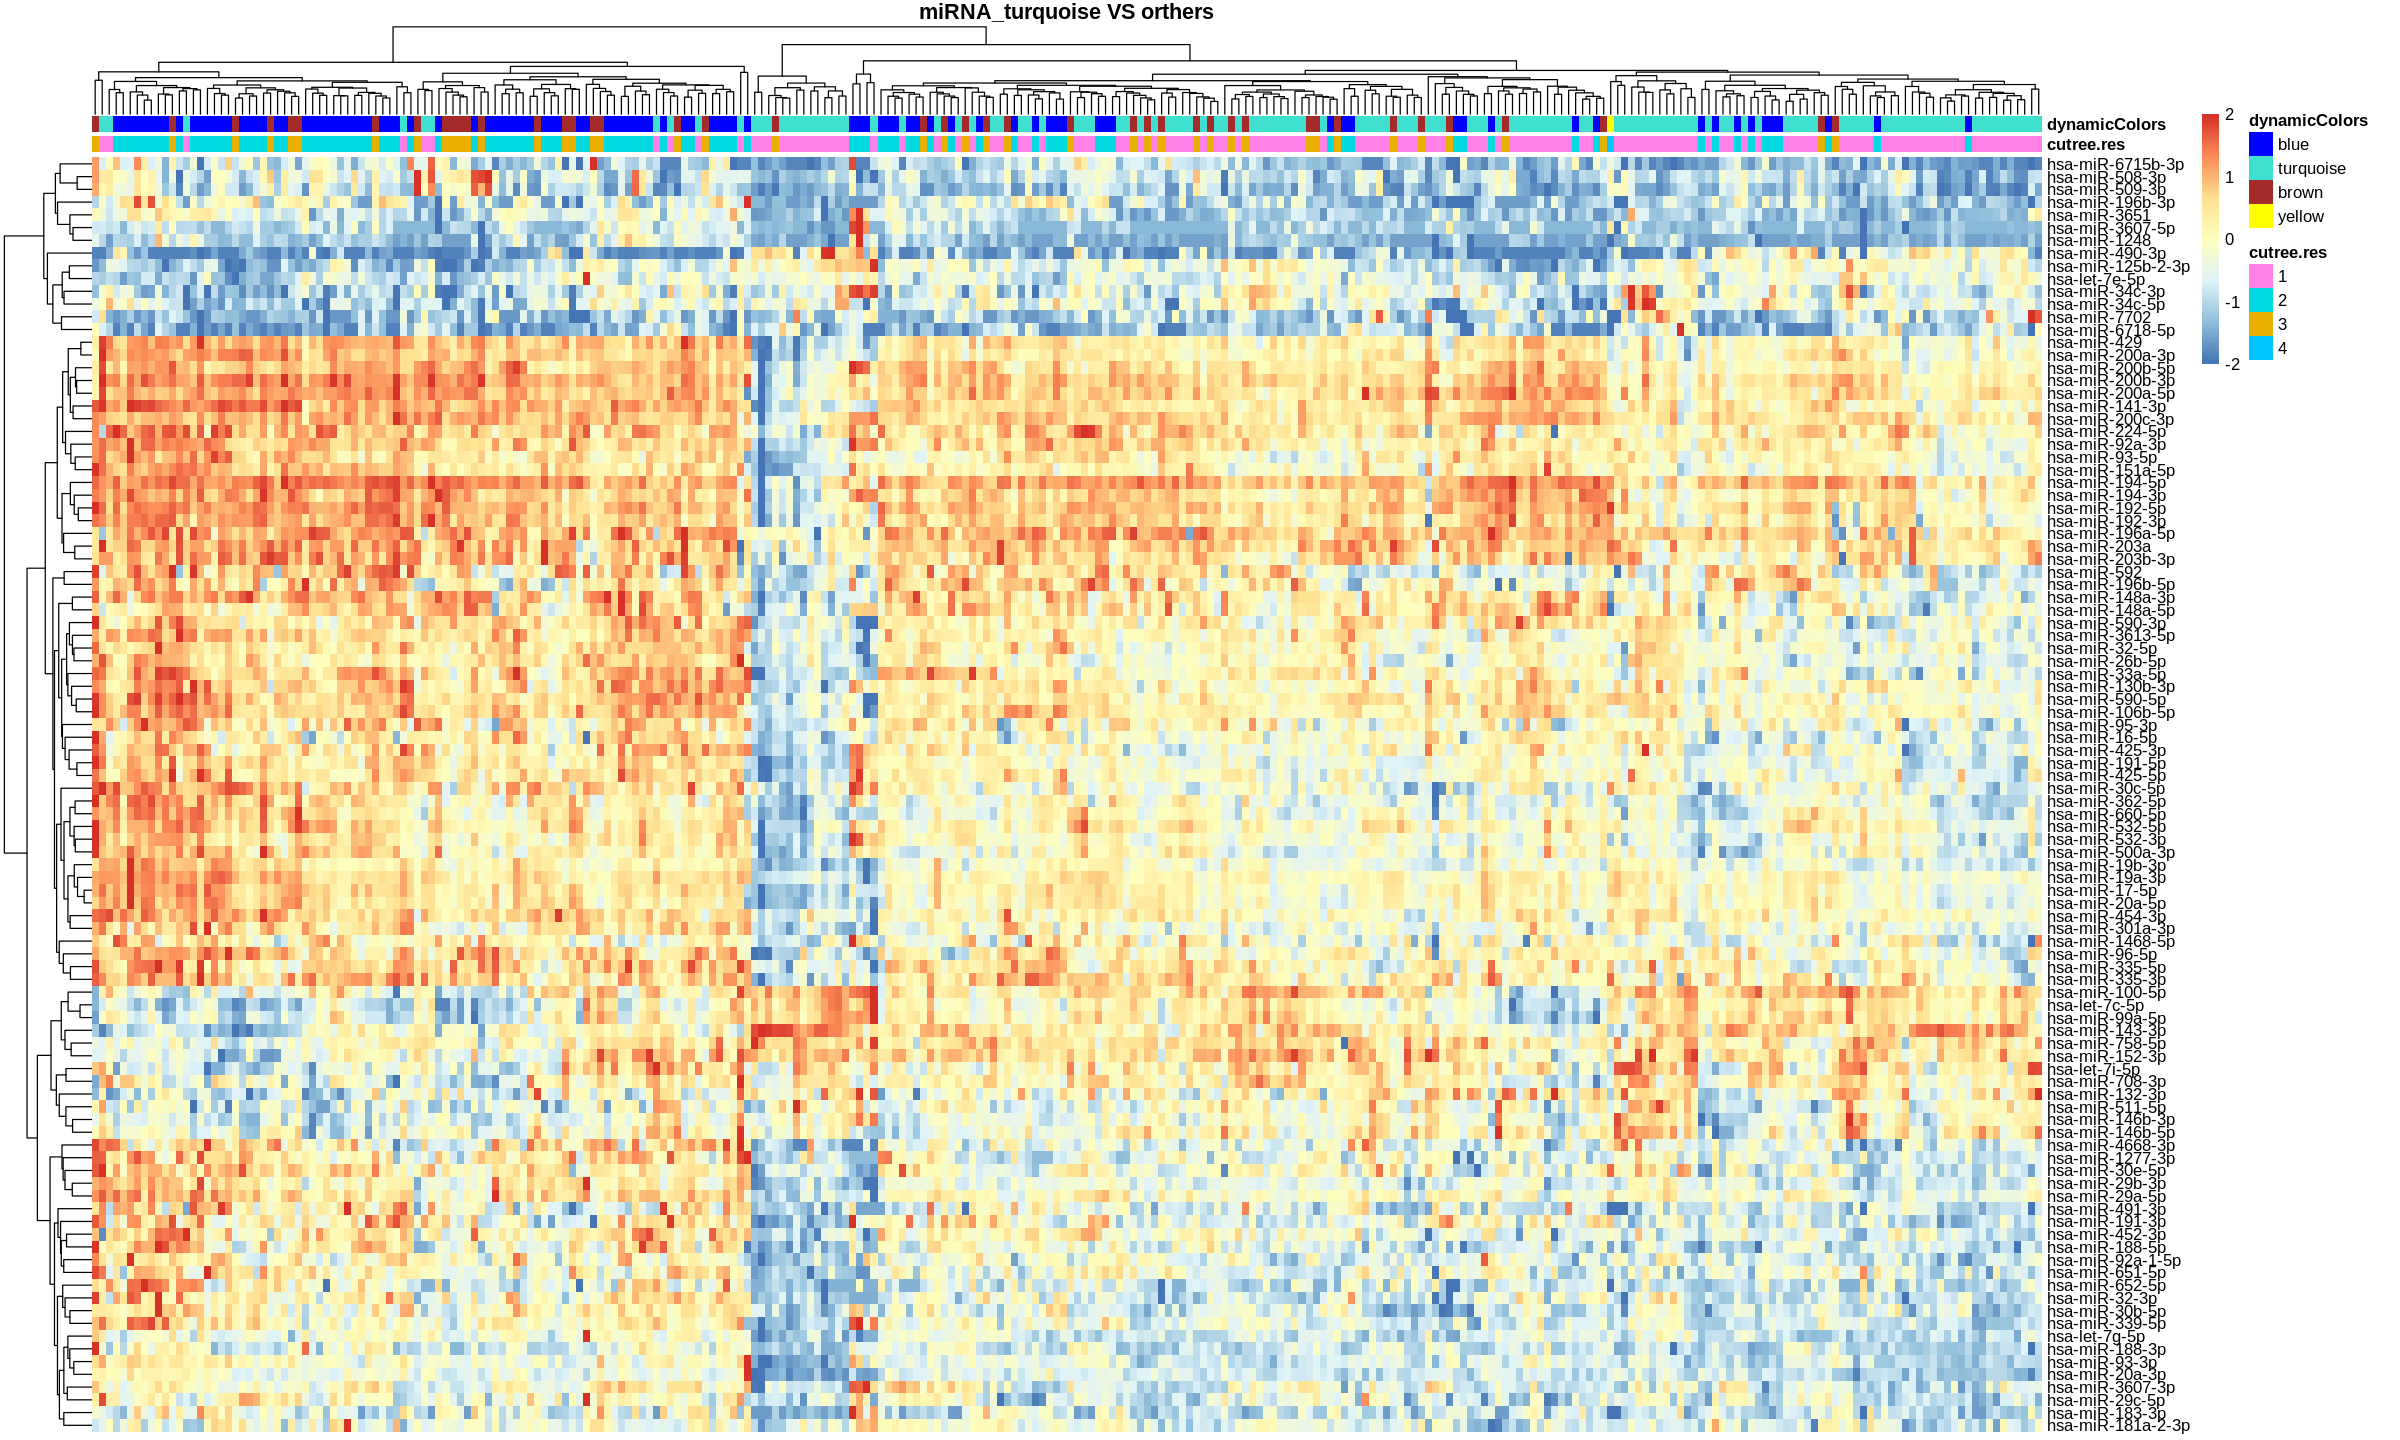

In [6]:
### 8) Ploting rescaled miRNAlation data
library(scales)
COAD.miRNA.scaled <- t(apply(COAD.miRNA.set, 1, rescale, to=c(-2,2)))
summary(COAD.miRNA.scaled[5,])
pheatmap::pheatmap(COAD.miRNA.scaled[rownames(miRNA.blue),],annotation_col = pData(COAD.miRNA.set)[,1:2],show_colnames = F,
                   main = "miRNA_Blue VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.miRNA.scaled[rownames(miRNA.brown),],annotation_col = pData(COAD.miRNA.set)[,1:2],show_colnames = F,
                   main = "miRNA_brown VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.miRNA.scaled[rownames(miRNA.turquoise),],annotation_col = pData(COAD.miRNA.set)[,1:2],show_colnames = F,
                   main = "miRNA_turquoise VS orthers",annotation_colors = ann_colors)


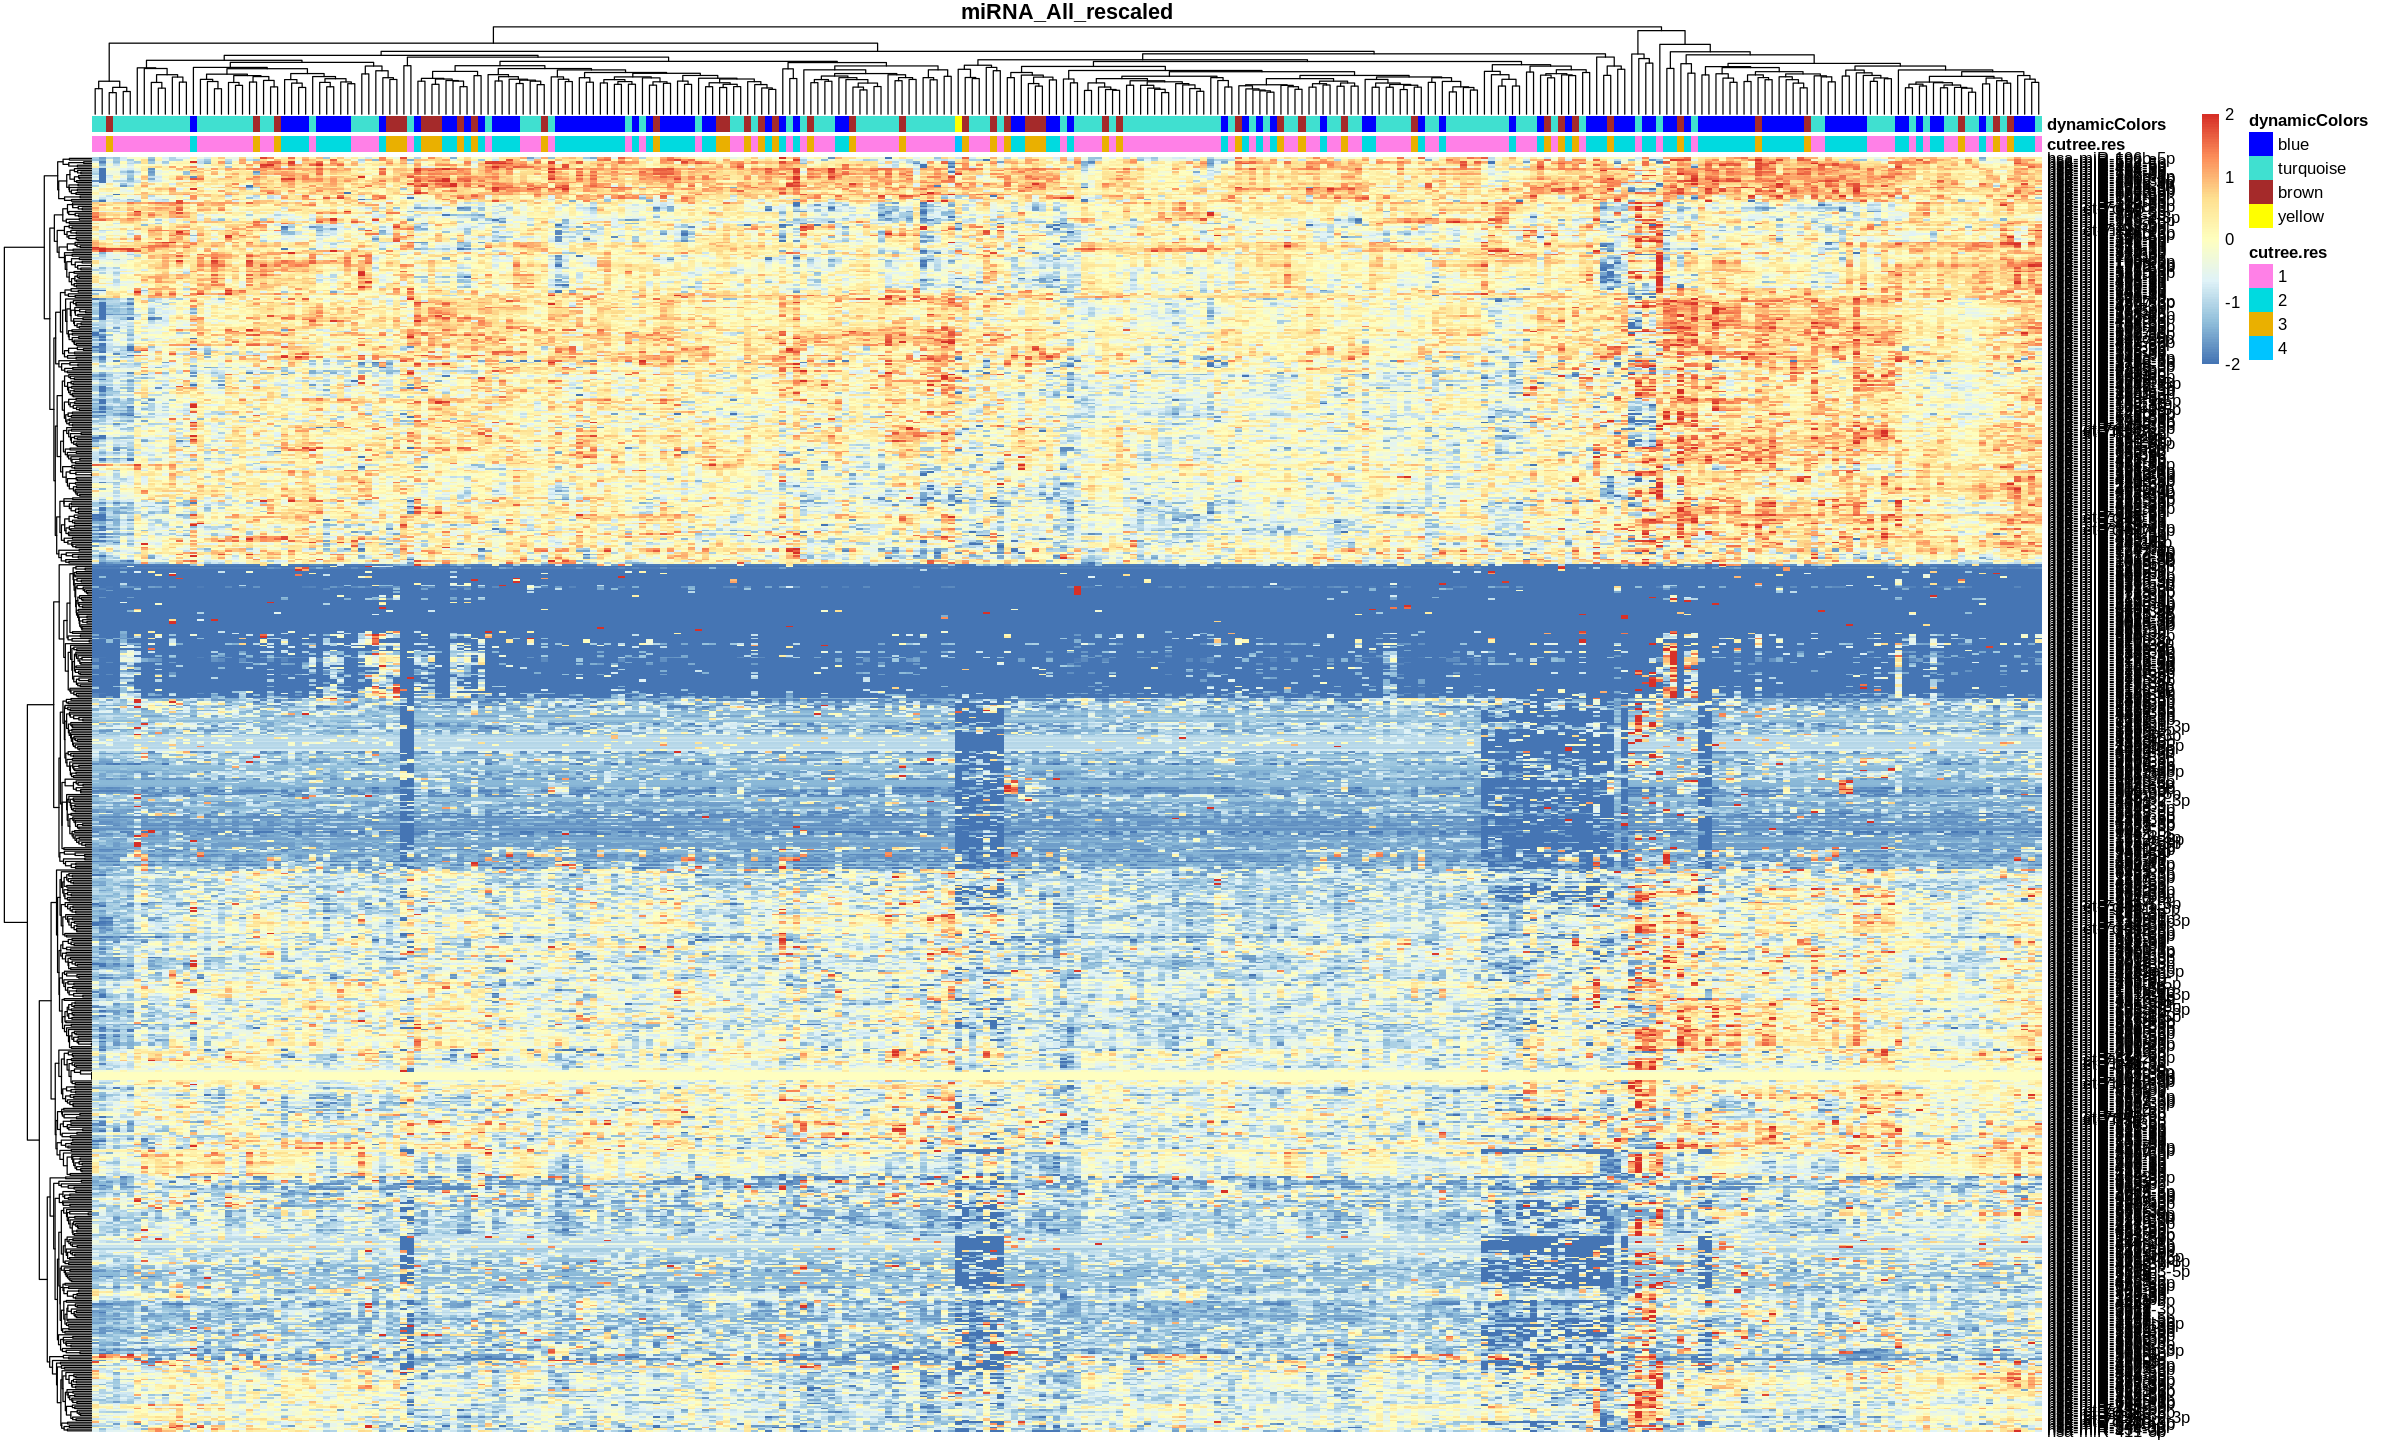

In [7]:
pheatmap::pheatmap(COAD.miRNA.scaled,annotation_col = pData(COAD.miRNA.set)[,1:2],show_colnames = F,
                   main = "miRNA_All_rescaled",annotation_colors = ann_colors)
